In [3]:
import argparse
import pandas as pd
import numpy as np
from numpy import savez_compressed, load
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from functools import reduce
en_stopwords = set(stopwords.words('english')) 
import itertools
import re
import time
import os
import pickle

import datasets
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets,DatasetDict
from datasets import load_from_disk
from tqdm import tqdm
tqdm.pandas(position=0,leave=True)


import textwrap

import transformers

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    get_linear_schedule_with_warmup,
)
print("Transformers version is {}".format(transformers.__version__))

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display, HTML

from collections import Counter
from wordcloud import WordCloud

sns.set(style="whitegrid",palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

%config InlineBackend.figure_format="retina"
%matplotlib inline

pd.set_option('display.max_columns', None,'display.max_rows',None)

Transformers version is 4.17.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
my_folder="s3://trident-retention-output/"
folder = 's3://trident-retention-data/askunum/'
churn_data=pd.read_pickle(os.path.join(my_folder,"churn_data_pickle"))
churn_data.head()

unum_id  policy_id pivot_date  year  month start_date   end_date  churn
0  GRA00956433     956433 2021-08-01  2021      8 2020-11-01 2021-05-01      1
1  GRA00956388     956388 2021-06-01  2021      6 2020-09-01 2021-03-01      1
2  GRA00955945     955945 2021-01-01  2021      1 2020-04-01 2020-10-01      1
3  GRA00955705     955705 2020-09-01  2020      9 2019-12-01 2020-06-01      1
4  GRA00955115     955115 2020-03-01  2020      3 2019-06-01 2019-12-01      1

In [5]:
email_all=load_from_disk(os.path.join(os.getcwd(),"dataset","email_all"))
email_all

DatasetDict({
    train: Dataset({
        features: ['unum_id', 'policy_id', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'month', 'email_counts', 'issue_counts', 'duration', 'subtype', 'churn'],
        num_rows: 156626
    })
    test: Dataset({
        features: ['unum_id', 'policy_id', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'month', 'email_counts', 'issue_counts', 'duration', 'subtype', 'churn'],
        num_rows: 26819
    })
})

In [ ]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]

In [ ]:
def churn_distribution(df):
    tempt1=pd.DataFrame(df["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
    tempt2=pd.DataFrame(df["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
    return tempt1.merge(tempt2, on="churn", how="inner")

def style_format(df,  data_type="Training set"):
    return df.style.format({'count':'{:,}','percentage':'{:.2%}'})\
           .set_caption(f"{data_type} churn distribution")\
           .set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

In [ ]:
churn_train=churn_distribution(df_train)
style_format(churn_train,  data_type="Training set")

In [ ]:
churn_test=churn_distribution(df_test)
style_format(churn_test,  data_type="Test set")

In [ ]:
df_train.head()

In [8]:
from datasets import Dataset
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
def train_test_data(df_train, df_test, feature_cols):
    train_df=Dataset.from_pandas(df_train)
    train_df=train_df.filter(lambda x: x[feature_cols]!=None)
    train_df=train_df.map(lambda x: tokenizer(x[feature_cols]),batched=True)

    test_df=Dataset.from_pandas(df_test)
    test_df=test_df.filter(lambda x: x[feature_cols]!=None)
    test_df=test_df.map(lambda x: tokenizer(x[feature_cols]),batched=True)
    
    def compute_lenth(example):
        return {"text_length":len(example["input_ids"])}
    
    train_df=train_df.map(compute_lenth)
    test_df=test_df.map(compute_lenth)
    
    return train_df, test_df

In [13]:
train_df1, test_df1=train_test_data(df_train, df_test, feature_cols="Full_TextBody")

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/156626 [00:00<?, ?ex/s]

  0%|          | 0/26819 [00:00<?, ?ex/s]

In [14]:
train_df2, test_df2=train_test_data(df_train, df_test, feature_cols="Client_TextBody")

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/156626 [00:00<?, ?ex/s]

  0%|          | 0/26819 [00:00<?, ?ex/s]

In [15]:
train_df3, test_df3=train_test_data(df_train, df_test, feature_cols="Latest_TextBody")

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/156626 [00:00<?, ?ex/s]

  0%|          | 0/26819 [00:00<?, ?ex/s]

In [16]:
def statistics_compute(hf_df1,hf_df2,p=1):

    X=[]
    X.append(np.percentile(hf_df1['text_length'],p))
    X.append(np.percentile(hf_df2['text_length'],p))
    
    result={}
    result['percentile']=X
    result["min"]=[np.min(hf_df1['text_length']),np.min(hf_df2['text_length'])]
    result["max"]=[np.max(hf_df1['text_length']),np.max(hf_df2['text_length'])]
    result["mean"]=[np.mean(hf_df1['text_length']),np.mean(hf_df2['text_length'])]
    return result

def statistics_table(hf_df1,hf_df2):
    dict_data={}
    dict_data["data_type"]=["training", "test"]
    dict_data["# of obs"]=[len(hf_df1['text_length']),len(hf_df2['text_length'])]
    dict_data["Min of tokens"]=statistics_compute(hf_df1, hf_df2)["min"]
    dict_data["1% of tokens"]=statistics_compute(hf_df1, hf_df2, p=1)['percentile']
    dict_data["5% of tokens"]=statistics_compute(hf_df1, hf_df2, p=5)['percentile']
    dict_data["10% of tokens"]=statistics_compute(hf_df1, hf_df2, p=10)['percentile']
    dict_data["25% of tokens"]=statistics_compute(hf_df1, hf_df2, p=25)['percentile']
    dict_data["Median of tokens"]=statistics_compute(hf_df1, hf_df2, p=50)['percentile']
    dict_data["Average tokens"]=statistics_compute(hf_df1, hf_df2)["mean"]
    dict_data["75% of tokens"]=statistics_compute(hf_df1, hf_df2, p=75)['percentile']
    dict_data["90% of tokens"]=statistics_compute(hf_df1, hf_df2, p=90)['percentile']
    dict_data["95% of tokens"]=statistics_compute(hf_df1, hf_df2, p=95)['percentile']
    dict_data["99% of tokens"]=statistics_compute(hf_df1, hf_df2, p=99)['percentile']
    dict_data["Max of tokens"]=statistics_compute(hf_df1, hf_df2)["max"]
    token_count_df=pd.DataFrame(dict_data)
    return token_count_df

def style_format(token_count_df,  textbody="Full_TextBody"):
    token_count_df=token_count_df.set_index("data_type")
    token_count_df[list(token_count_df.columns)] = token_count_df[list(token_count_df.columns)].astype(int)
    return token_count_df.style.format("{:,}").set_caption(f"Summary Statistics of token lengths for {textbody} ").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [17]:
token_count_df=statistics_table(train_df1,test_df1)
style_format(token_count_df,  textbody="Full_TextBody")

In [18]:
token_count_df=statistics_table(train_df2,test_df2)
style_format(token_count_df,  textbody="Client_TextBody")

In [19]:
token_count_df=statistics_table(train_df3,test_df3)
style_format(token_count_df,  textbody="Latest_TextBody")

In [20]:
train_df1.set_format("pandas")
df1_train=train_df1[:]
train_df2.set_format("pandas")
df2_train=train_df2[:]
train_df3.set_format("pandas")
df3_train=train_df3[:]

test_df1.set_format("pandas")
df1_test=train_df1[:]
test_df2.set_format("pandas")
df2_test=test_df2[:]
test_df3.set_format("pandas")
df3_test=test_df3[:]

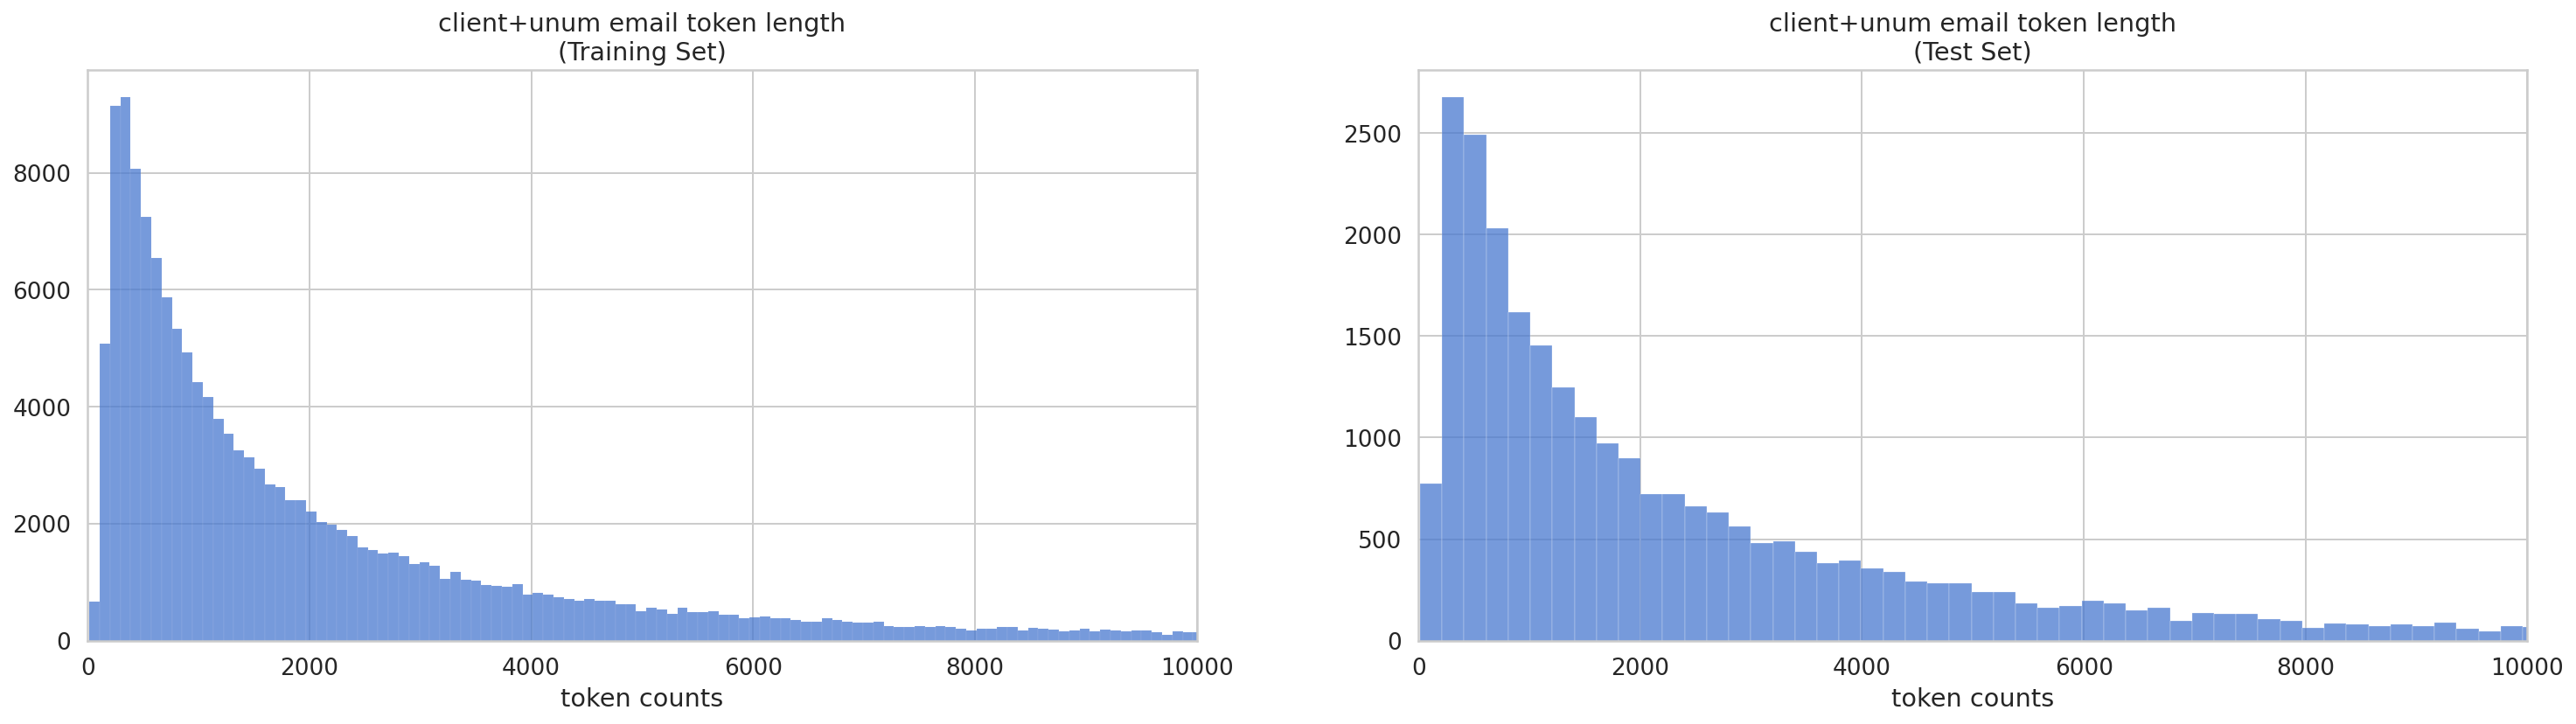

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df1['text_length'],ax=ax1)
ax1.set_title("client+unum email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 10000))

sns.histplot(test_df1['text_length'],ax=ax2)
ax2.set_title("client+unum email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 10000))
plt.show()

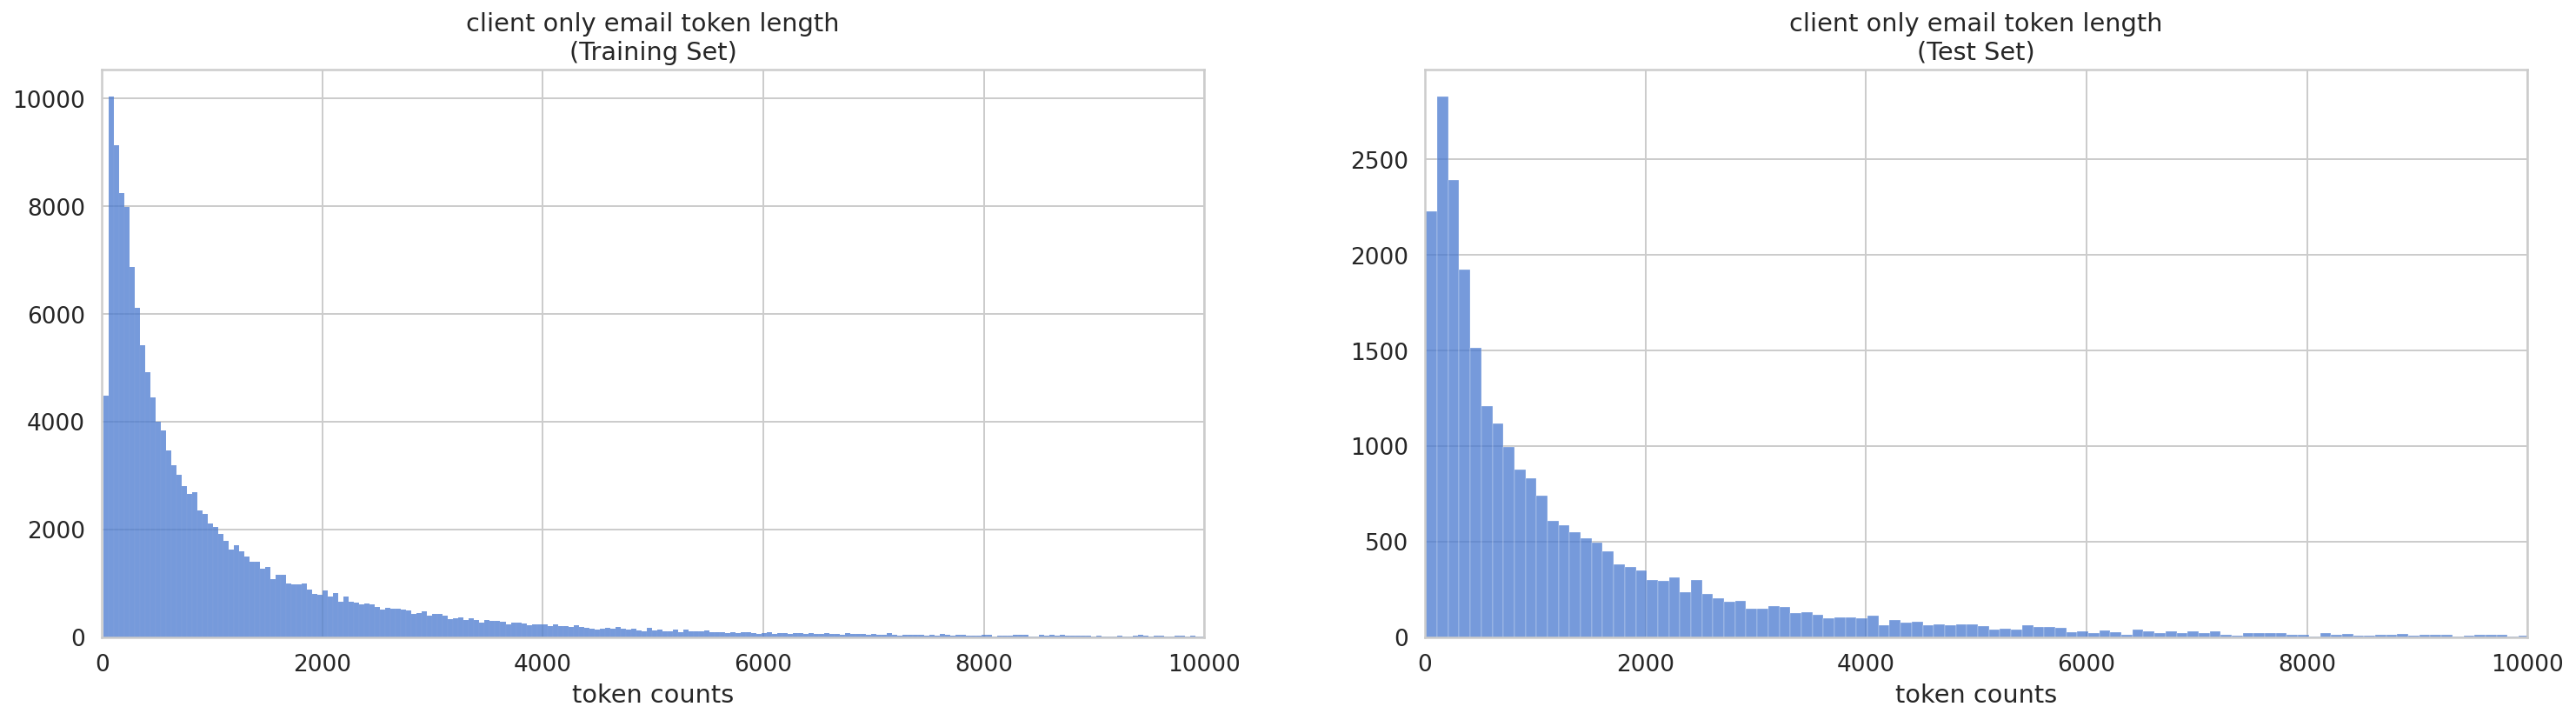

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df2['text_length'],ax=ax1)
ax1.set_title("client only email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 10000))

sns.histplot(test_df2['text_length'],ax=ax2)
ax2.set_title("client only email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 10000))
plt.show()

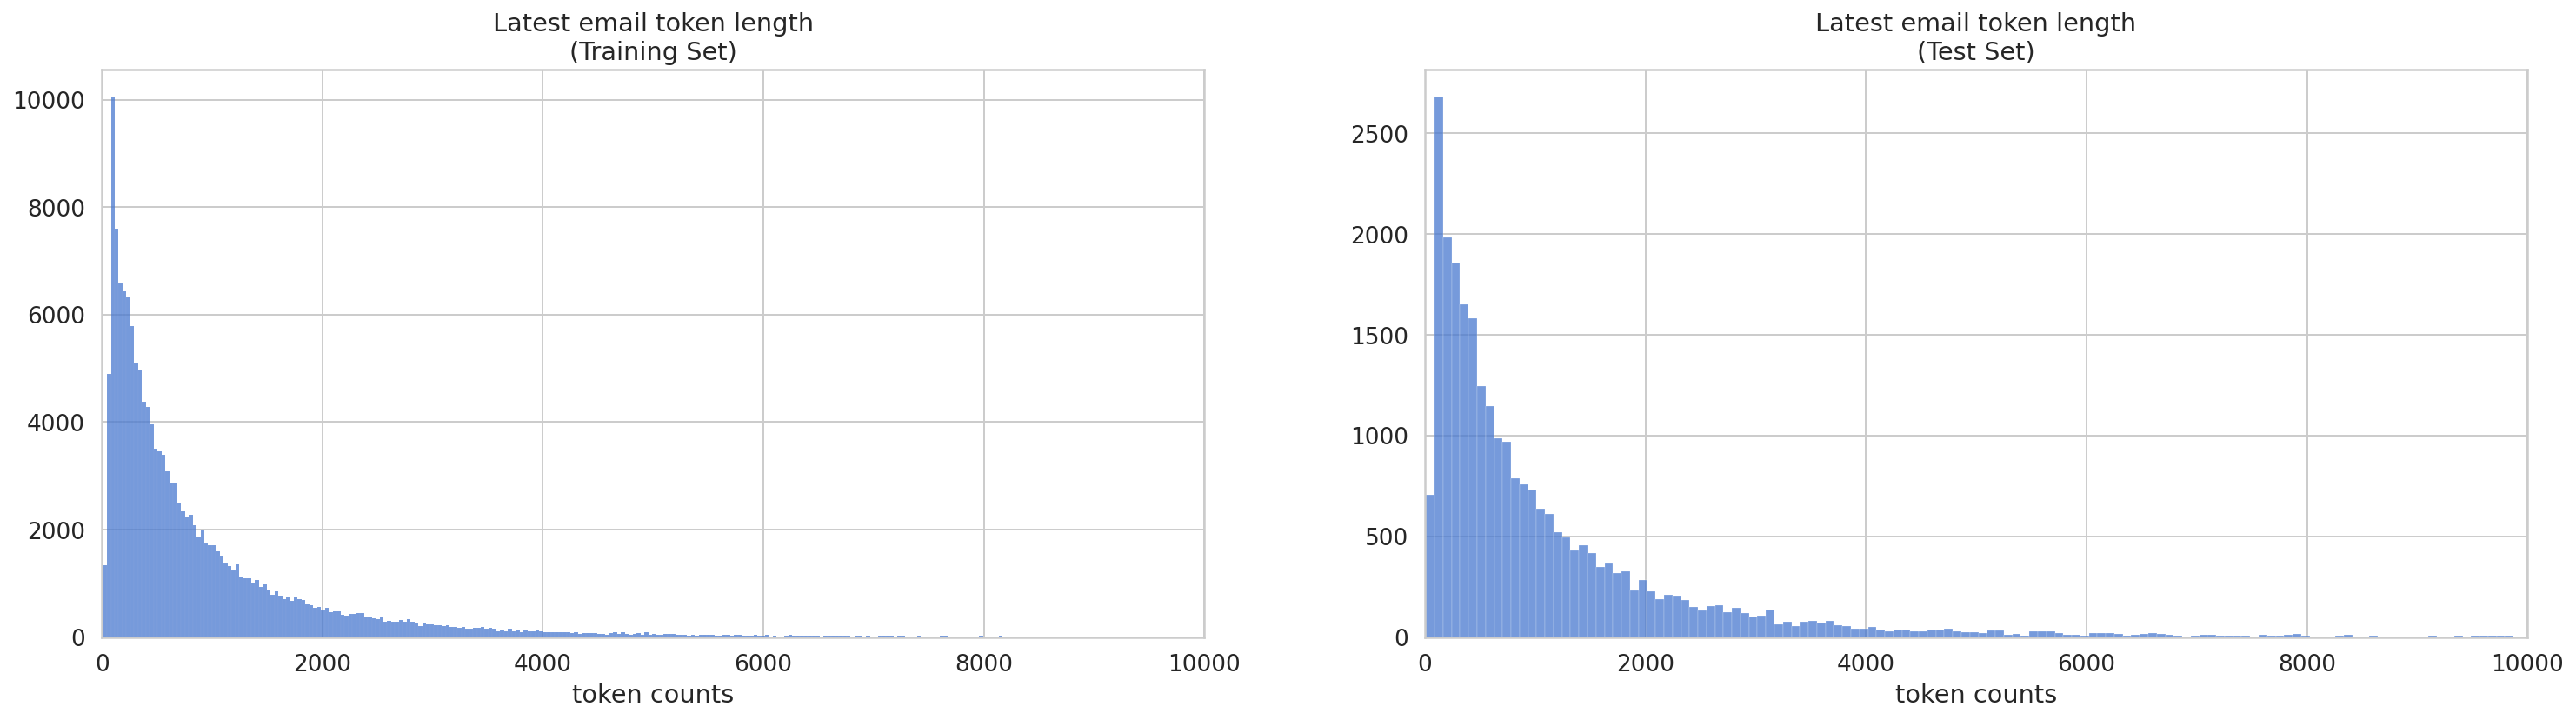

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df3['text_length'],ax=ax1)
ax1.set_title("Latest email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 10000))

sns.histplot(test_df3['text_length'],ax=ax2)
ax2.set_title("Latest email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 10000))
plt.show()

In [ ]:
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    
hf_train.set_format(type="pandas")
df_train=hf_train[:]

hf_test.set_format(type="pandas")
df_test=hf_test[:]

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
all_stopwords_gensim = STOPWORDS.union(set(['thank','thanks', 'you', 'help','questions','a.m.','p.m.','friday','thursday','wednesday','tuesday','monday',\
                                            'askunum','email','askunum.com','unum','askunumunum.com','day','use', 'appreciate','available','mailtoaskunumunum.com',\
                                            'hello','hi','online','?','.','. .','phone','needs','need','let','know','service','information','time','meet','client',\
                                           'team','ask','file','date','opportunity','original','benefit','eastern','specialists','specialist','attached','experienced',\
                                            'benefits insurance','employee','click','organization','httpsbit.lycjrbm',  'received', 'billing', 'manager', 'assist', \
                                            'additional', 'response']))


## remove stop word
df_train["Full_TextBody"] = df_train["Full_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))
df_test["Full_TextBody"] = df_test["Full_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

df_train["Latest_TextBody"] = df_train["Latest_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))
df_test["Latest_TextBody"] = df_test["Latest_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

## removing non-english words from text
words = set(nltk.corpus.words.words())
df_train["Full_TextBody"] = df_train["Full_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
df_test["Full_TextBody"] = df_test["Full_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

df_train["Latest_TextBody"] = df_train["Latest_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
df_test["Latest_TextBody"] = df_test["Latest_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

## removing punctuation
df_train["Full_TextBody"]=df_train["Full_TextBody"].str.replace(r'[^\w\s]+', '')
df_test["Full_TextBody"]=df_test["Full_TextBody"].str.replace(r'[^\w\s]+', '')

df_train["Latest_TextBody"]=df_train["Full_TextBody"].str.replace(r'[^\w\s]+', '')
df_test["Latest_TextBody"]=df_test["Full_TextBody"].str.replace(r'[^\w\s]+', '')

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,6))
df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_train.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax1)
ax1.set_title("token length per email \n(Training set)")
ax1.set_ylabel("# of token")
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)
df_test.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax2)
ax2.set_title("token length per email \n(Test set)")
ax2.set_ylabel("# of token")
plt.show()

### Keyword Extraction

In [18]:
import time
import os
import re
import pandas as pd
import numpy as np
import datasets
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets,DatasetDict
from datasets import load_from_disk
from tqdm import tqdm
tqdm.pandas(position=0,leave=True)
import itertools
import spacy
nlp = spacy.load("en_core_web_md")
from textblob import TextBlob
# python -m textblob.download_corpora
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
sns.set(style="whitegrid",palette='muted',font_scale=1.2)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
all_stopwords_gensim = STOPWORDS.union(set(['thank','thanks', 'you', 'help','questions','a.m.','p.m.','friday','thursday','wednesday','tuesday','monday',\
                                            'askunum','email','askunum.com','unum','askunumunum.com','day','use', 'appreciate','available','mailtoaskunumunum.com',\
                                            'hello','hi','online','?','.','. .','phone','needs','need','let','know','service','information','time','meet','client',\
                                           'team','ask','file','date','opportunity','original','benefit','eastern','specialists','specialist','attached','experienced',\
                                            'benefits insurance','employee','click','organization','httpsbit.lycjrbm',  'received', 'billing', 'manager', 'assist', \
                                            'additional', 'response','vlif']))

In [4]:
def text_preprocess(text, extract_adj=False):
    # lemma = nltk.wordnet.WordNetLemmatizer()
    
    text = str(text)
    
    #remove http links from the email
    
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], '')  
    
    text = re.sub("`", "'", text)
    
    #fix misspelled words

    '''Here we are not actually building any complex function to correct the misspelled words but just checking that each character 
    should occur not more than 2 times in every word. It’s a very basic misspelling check.'''

    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    
    if extract_adj:
        ADJ_word=[]
        doc=nlp(text)
        for token in doc:
            if token.pos_=="ADJ":
                ADJ_word.append(token.text)   
        text=" ".join(ADJ_word)    

    # text = [appos[word] if word in appos else word for word in text.lower().split()]
    # text = " ".join(text)
    
    ### Remove stop word
    text = [i for i in word_tokenize(text) if i not in all_stopwords_gensim]
    text = " ".join(text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text.split()]
    text=" ".join(text)
    
    # stem
    # ps = PorterStemmer()
    # text=" ".join(set([ps.stem(w) for w in text.split()]))
    
    return text
    
def textblob_sentiment(text):
    pol_score = TextBlob(text).sentiment.polarity
    if pol_score > 0: 
        return 'positive'
    elif pol_score == 0: 
        return 'neutral'
    else: 
        return 'negative'

def vader_sentiment(text):
    
    senti = SentimentIntensityAnalyzer()
    compound_score = senti.polarity_scores(text)['compound']
    
    # set sentiment 
    if compound_score >= 0.05: 
        return 'positive'
    elif (compound_score > -0.05) and (compound_score < 0.05): 
        return 'neutral'
    else: 
        return 'negative'

In [5]:
email_all=load_from_disk(os.path.join(os.getcwd(),"dataset","email_all"))
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]

def churn_distribution(df):
    tempt1=pd.DataFrame(df["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
    tempt2=pd.DataFrame(df["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
    return tempt1.merge(tempt2, on="churn", how="inner")

def style_format(df,  data_type="Training set"):
    return df.style.format({'count':'{:,}','percentage':'{:.2%}'})\
           .set_caption(f"{data_type} churn distribution")\
           .set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

In [6]:
churn_train=churn_distribution(df_train)
style_format(churn_train,  data_type="Training set")

In [7]:
churn_test=churn_distribution(df_test)
style_format(churn_test,  data_type="Test set")

In [30]:
df_train["bag_of_word"]=df_train["Full_TextBody"].progress_apply(text_preprocess)
df_test["bag_of_word"]=df_test["Full_TextBody"].progress_apply(text_preprocess)

100%|██████████| 26819/26819 [07:11<00:00, 62.09it/s] 


In [ ]:
# df_train["adj_bag_of_word"]=df_train["Full_TextBody"].progress_apply(lambda x: text_preprocess(x, extract_adj=True))
# df_test["adj_bag_of_word"]=df_test["Full_TextBody"].progress_apply(lambda x: text_preprocess(x, extract_adj=True))

In [9]:
my_folder="s3://trident-retention-output/"
# df_train.to_pickle(os.path.join(my_folder,"df_train"))
# df_test.to_pickle(os.path.join(my_folder,"df_test"))
df_train=pd.read_pickle(os.path.join(my_folder,"df_train"))
df_test=pd.read_pickle(os.path.join(my_folder,"df_test"))

In [10]:
## removing non-english words from text
words = set(nltk.corpus.words.words())
df_train["adj_bag_of_word"] = df_train["adj_bag_of_word"].progress_apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ))
df_test["adj_bag_of_word"] = df_test["adj_bag_of_word"].progress_apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ))

df_train["bag_of_word"] = df_train["bag_of_word"].progress_apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ))
df_test["bag_of_word"] = df_test["bag_of_word"].progress_apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ))

## removing short text
df_train["adj_bag_of_word"] = df_train["adj_bag_of_word"].progress_apply(lambda x: " ".join(w for w in x.split() if len(w)>=3) )
df_test["adj_bag_of_word"] = df_test["adj_bag_of_word"].progress_apply(lambda x: " ".join(w for w in x.split() if len(w)>=3))

df_train["bag_of_word"] = df_train["bag_of_word"].progress_apply(lambda x: " ".join(w for w in x.split() if len(w)>=3))
df_test["bag_of_word"] = df_test["bag_of_word"].progress_apply(lambda x: " ".join(w for w in x.split() if len(w)>=3))

100%|██████████| 26819/26819 [00:01<00:00, 16950.15it/s]


In [11]:
def most_common_word(df,feature):
    word_count=Counter()
    for index,row in tqdm(df.iterrows(), total=df.shape[0]):
        word_count.update(set(row[feature].split()))
    word,freq=zip(*word_count.most_common())
    return word,freq

In [12]:
train_churn,  train_no_churn=df_train[df_train['churn']==1], df_train[df_train['churn']==0]
test_churn,  test_no_churn=df_test[df_test['churn']==1], df_test[df_test['churn']==0]

word_train_churn, freq_train_churn = most_common_word(train_churn, feature="bag_of_word")
word_test_churn, freq_test_churn = most_common_word(test_churn, feature="bag_of_word")
word_train_no_churn, freq_train_no_churn = most_common_word(train_no_churn, feature="bag_of_word")
word_test_no_churn, freq_test_no_churn = most_common_word(test_no_churn, feature="bag_of_word")

keyword_training=[w for w in word_train_churn if w not in word_train_no_churn]
keyword_test=[w for w in word_test_churn if w not in word_test_no_churn]

dict_data={}
dict_data["training"]=keyword_training[0:50]
dict_data["test"]=keyword_test[0:50]
pd.DataFrame(dict_data).style.format().set_caption("Most common keywords only in churn==1")\
.set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

100%|██████████| 23149/23149 [00:02<00:00, 9485.12it/s] 


In [13]:
# https://ptrckprry.com/course/ssd/data/negative-words.txt
# https://gist.github.com/mkulakowski2/4289441#file-negative-words-txt
# Opinion Lexicon: Negative
# negative-words.txt contains a list of NEGATIVE opinion words (or sentiment words).
negative_word=[]
with open("negative-words.txt") as f:
    for curline in f:
        if curline.startswith(";"):
            continue
        if curline.strip():
            negative_word.append(curline.strip())
print("There are {:,} negative words externally".format(len(negative_word)))

There are 4,783 negative words externally


In [14]:
from random import sample
print(sample(negative_word,50))

['overbearing', 'limitation', 'distrusting', 'mercilessly', 'macabre', 'unachievable', 'mist', 'boiling', 'ripoff', 'vomited', 'unusable', 'temper', 'asunder', 'unhappy', 'ignoble', 'rogue', 'slack', 'troubles', 'uneconomical', 'objection', 'dawdle', 'sidetrack', 'juddering', 'curt', 'inculcate', 'non-confidence', 'fallacy', 'denial', 'odder', 'hissed', 'disconsolately', 'sorely', 'tease', 'partisan', 'molestation', 'untruthful', 'unexpected', 'drained', 'disavow', 'scowl', 'disturbingly', 'stigmatize', 'mists', 'cruel', 'hardliners', 'satirical', 'mismanage', 'cussed', 'ail', 'spade']


In [15]:
train_df=df_train.copy()
test_df=df_test.copy()
train_df['negative_word_counts'] = 0
test_df['negative_word_counts'] = 0
for w in tqdm(negative_word, total=len(negative_word)):
    train_df['negative_word_counts']+=train_df["bag_of_word"].apply(lambda x: w in x)
    test_df['negative_word_counts']+=test_df["bag_of_word"].apply(lambda x: w in x)

100%|██████████| 4783/4783 [37:56<00:00,  2.10it/s]


In [16]:
def negative_keyword_churn_ratio(df,num_neg):
    tempt=df[df['negative_word_counts']<=num_neg]
    ratio=tempt[tempt["churn"]==1].shape[0]/tempt.shape[0]
    return (num_neg,ratio)

train_neg_keyword_churn=[]
test_neg_keyword_churn=[]
max_num=min(train_df['negative_word_counts'].max(), test_df['negative_word_counts'].max())
for i in range(0,max_num,5):
    train_neg_keyword_churn.append(negative_keyword_churn_ratio(train_df,i))
    test_neg_keyword_churn.append(negative_keyword_churn_ratio(test_df,i))

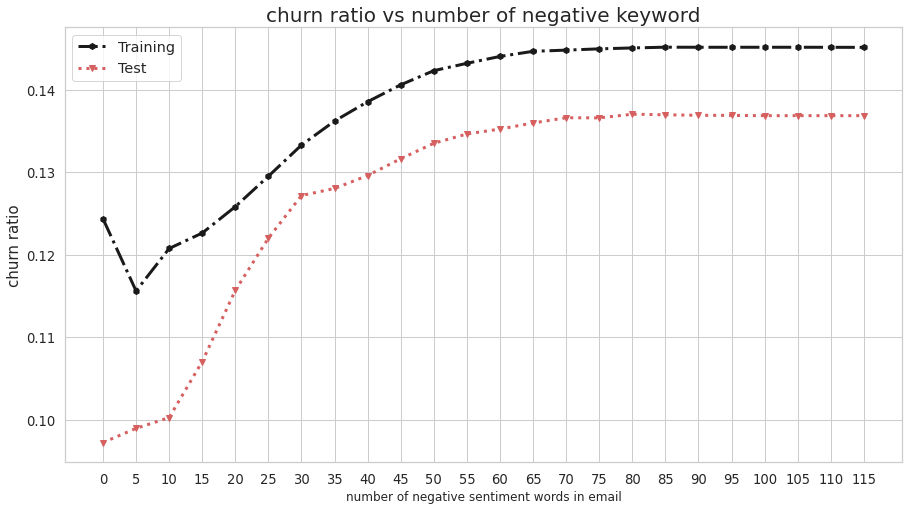

In [19]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot([int(x[0]) for x in train_neg_keyword_churn],  [x[1] for x in train_neg_keyword_churn], label = "Training",color='k',marker='h', linestyle="-.", linewidth=3)
plt.plot([int(x[0]) for x in test_neg_keyword_churn],  [x[1] for x in test_neg_keyword_churn], label = "Test",color='r',marker='v', linestyle=":", linewidth=3)
# plt.axvline(x=8, color='b')
plt.legend(fontsize="x-large")
plt.title("churn ratio vs number of negative keyword",fontsize=20)
plt.ylabel("churn ratio",fontsize=15)
plt.xlabel("number of negative sentiment words in email",fontsize=12)
# plt.xticks(rotation=90)
plt.xticks(np.arange(0, max_num, 5))
plt.show()

In [26]:
train_df['negative_word_set']=train_df["bag_of_word"].progress_apply(lambda x: set(x.split()).intersection(set(negative_word)))
test_df['negative_word_set']=test_df["bag_of_word"].progress_apply(lambda x: set(x.split()).intersection(set(negative_word)))


train_churn,  train_no_churn=train_df[train_df['churn']==1], train_df[train_df['churn']==0]
test_churn,  test_no_churn=test_df[test_df['churn']==1], test_df[test_df['churn']==0]

def most_common_word(df,feature):
    word_count=Counter()
    for index,row in tqdm(df.iterrows(), total=df.shape[0]):
        if isinstance(row[feature],list):
            word_count.update(set(row[feature].split()))
        elif isinstance(row[feature],set):
            word_count.update(row[feature])
    word,freq=zip(*word_count.most_common())
    return word,freq

word_train_churn, freq_train_churn = most_common_word(train_churn, feature="negative_word_set")
word_test_churn, freq_test_churn = most_common_word(test_churn, feature="negative_word_set")
word_train_no_churn, freq_train_no_churn = most_common_word(train_no_churn, feature="negative_word_set")
word_test_no_churn, freq_test_no_churn = most_common_word(test_no_churn, feature="negative_word_set")

# keyword_training=[w for w in word_train_churn if w not in word_train_no_churn]
# keyword_test=[w for w in word_test_churn if w not in word_test_no_churn]

dict_data={}
dict_data["training"]=word_train_churn[0:50]
dict_data["test"]=word_test_churn[0:50]
pd.DataFrame(dict_data).style.format().set_caption("Most common negative sentiment word in churn==1")\
.set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])                                                        

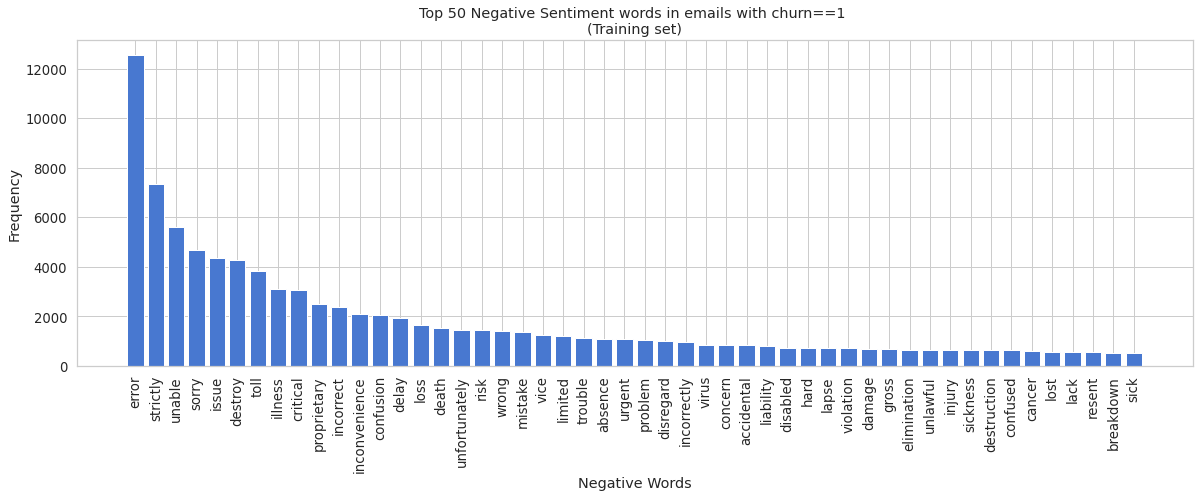

In [48]:
from matplotlib import pyplot as plt
word_list=[*zip(word_train_churn, freq_train_churn)]
xs=[i[0] for i in word_list][0:50]
ys=[i[1] for i in word_list][0:50]
plt.figure(figsize=(20,6))
plt.bar(xs, ys)
plt.xlabel('Negative Words')
plt.ylabel('Frequency')
plt.title('Top 50 Negative Sentiment words in emails with churn==1 \n(Training set)')
plt.xticks(rotation=90)
plt.show()

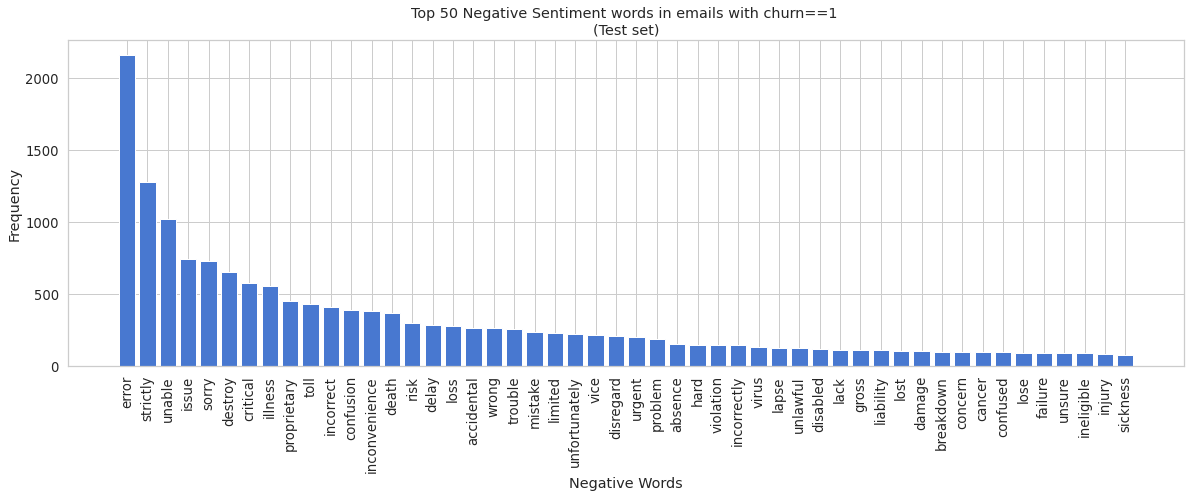

In [49]:
from matplotlib import pyplot as plt
word_list=[*zip(word_test_churn, freq_test_churn)]
xs=[i[0] for i in word_list][0:50]
ys=[i[1] for i in word_list][0:50]
plt.figure(figsize=(20,6))
plt.bar(xs, ys)
plt.xlabel('Negative Words')
plt.ylabel('Frequency')
plt.title('Top 50 Negative Sentiment words in emails with churn==1 \n(Test set)')
plt.xticks(rotation=90)
plt.show()

In [53]:
train_churn_dict=dict(zip(word_train_churn, freq_train_churn))
test_churn_dict=dict(zip(word_test_churn, freq_test_churn))

train_no_churn_dict=dict(zip(word_train_no_churn, freq_train_no_churn))
test_no_churn_dict=dict(zip(word_test_no_churn, freq_test_no_churn))

keyword_training=[w for w in word_train_churn if w not in word_train_no_churn]
keyword_test=[w for w in word_test_churn if w not in word_test_no_churn]

word_train_only_churn={x:train_churn_dict[x] for x in keyword_training}
# word_train_only_churn=sorted(word_train_only_churn, key=word_train_only_churn.get, reverse=True)

word_test_only_churn={x:test_churn_dict[x] for x in keyword_test}
# word_test_only_churn=sorted(word_test_only_churn, key=word_test_only_churn.get, reverse=True)

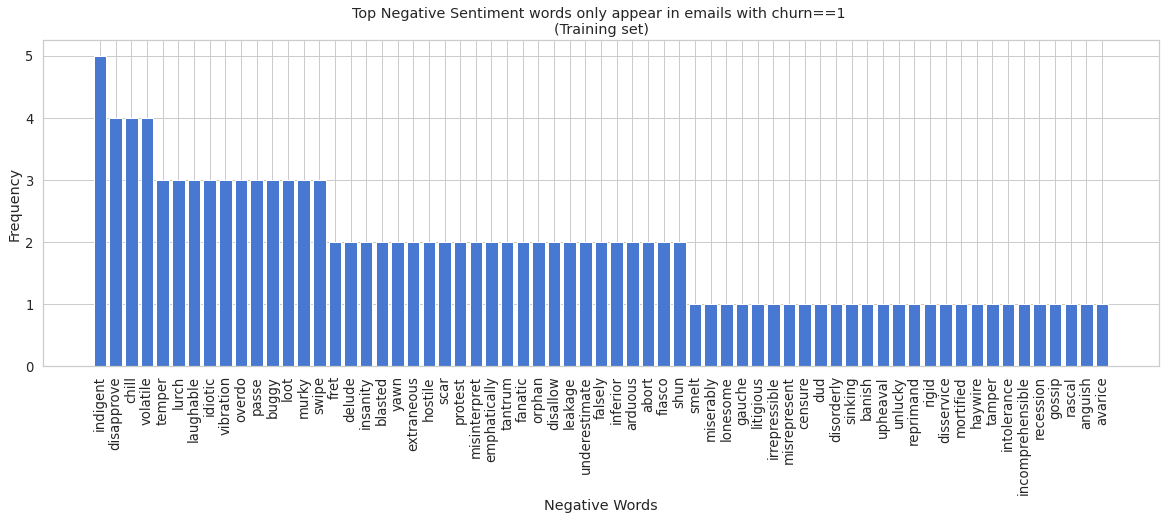

In [61]:
from matplotlib import pyplot as plt
xs=[k for k,v in word_train_only_churn.items()]
ys=[v for k,v in word_train_only_churn.items()]
plt.figure(figsize=(20,6))
plt.bar(xs, ys)
plt.xlabel('Negative Words')
plt.ylabel('Frequency')
plt.title('Top Negative Sentiment words only appear in emails with churn==1 \n(Training set)')
plt.xticks(rotation=90)
plt.show()

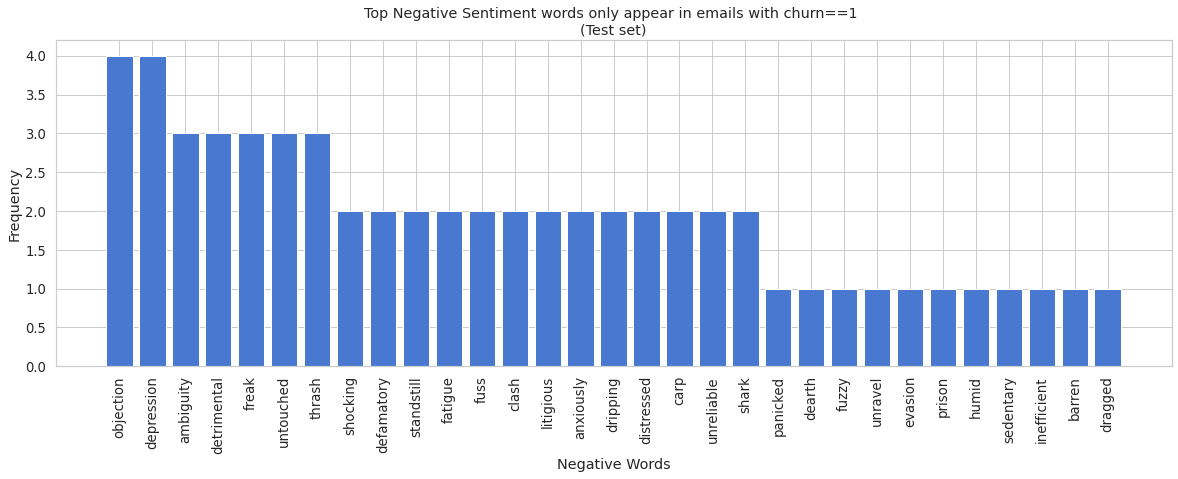

In [62]:
from matplotlib import pyplot as plt
xs=[k for k,v in word_test_only_churn.items()]
ys=[v for k,v in word_test_only_churn.items()]
plt.figure(figsize=(20,6))
plt.bar(xs, ys)
plt.xlabel('Negative Words')
plt.ylabel('Frequency')
plt.title('Top Negative Sentiment words only appear in emails with churn==1 \n(Test set)')
plt.xticks(rotation=90)
plt.show()

100%|██████████| 183445/183445 [00:07<00:00, 23726.39it/s]


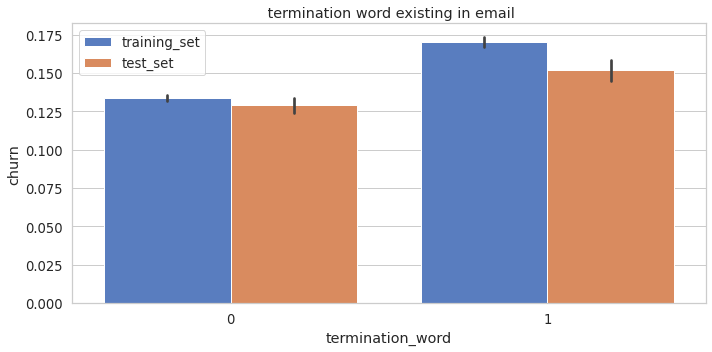

In [85]:
tempt1=train_df.copy()
tempt1["data_type"]=["training_set"]*len(tempt1)
tempt2=test_df.copy()
tempt2["data_type"]=["test_set"]*len(tempt2)
tempt=pd.concat([tempt1,tempt2],axis=0)

word=['terminate','termination','unsubscribe','unsubscribed','discontinue','discontinued']
tempt["termination_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(data = tempt, x='termination_word',y='churn',hue="data_type")
ax.set_title(" termination word existing in email")
plt.legend(loc="best")

100%|██████████| 183427/183427 [00:07<00:00, 24210.80it/s]


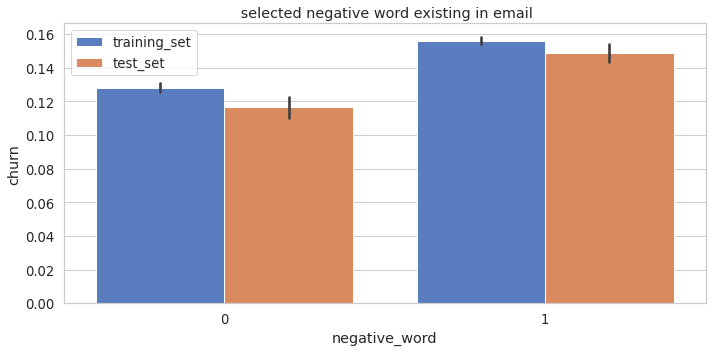

In [251]:
tempt1=train_df.copy()
tempt1["data_type"]=["training_set"]*len(tempt1)
tempt2=test_df.copy()
tempt2["data_type"]=["test_set"]*len(tempt2)
tempt=pd.concat([tempt1,tempt2],axis=0)

word=["frustration","frustrated","frustrate","unacceptable","apologies","apologize","error","incorrect","incorrectly","inconvenience","unfortunately","wrong"]
tempt["negative_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(data = tempt, x='negative_word',y='churn',hue="data_type")
ax.set_title(" selected negative word existing in email")
plt.legend(loc="best")

100%|██████████| 183427/183427 [00:07<00:00, 24015.31it/s]


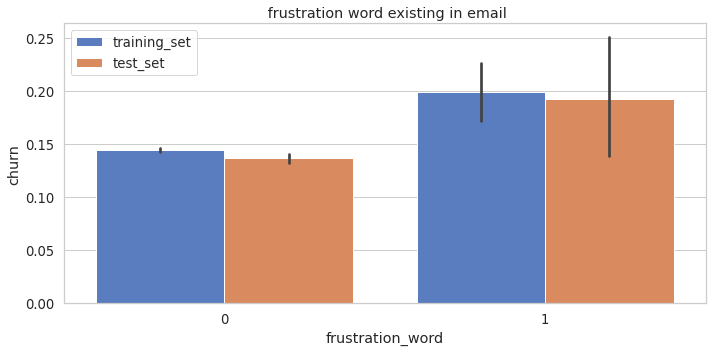

In [260]:
tempt1=train_df.copy()
tempt1["data_type"]=["training_set"]*len(tempt1)
tempt2=test_df.copy()
tempt2["data_type"]=["test_set"]*len(tempt2)
tempt=pd.concat([tempt1,tempt2],axis=0)

word=["frustration","frustrated","frustrate","unacceptable"]
tempt["frustration_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(data = tempt, x='frustration_word',y='churn',hue="data_type")
ax.set_title(" frustration word existing in email")
plt.legend(loc="best")

In [261]:
tempt["frustration_word"].value_counts()

0    182317
1      1110
Name: frustration_word, dtype: int64

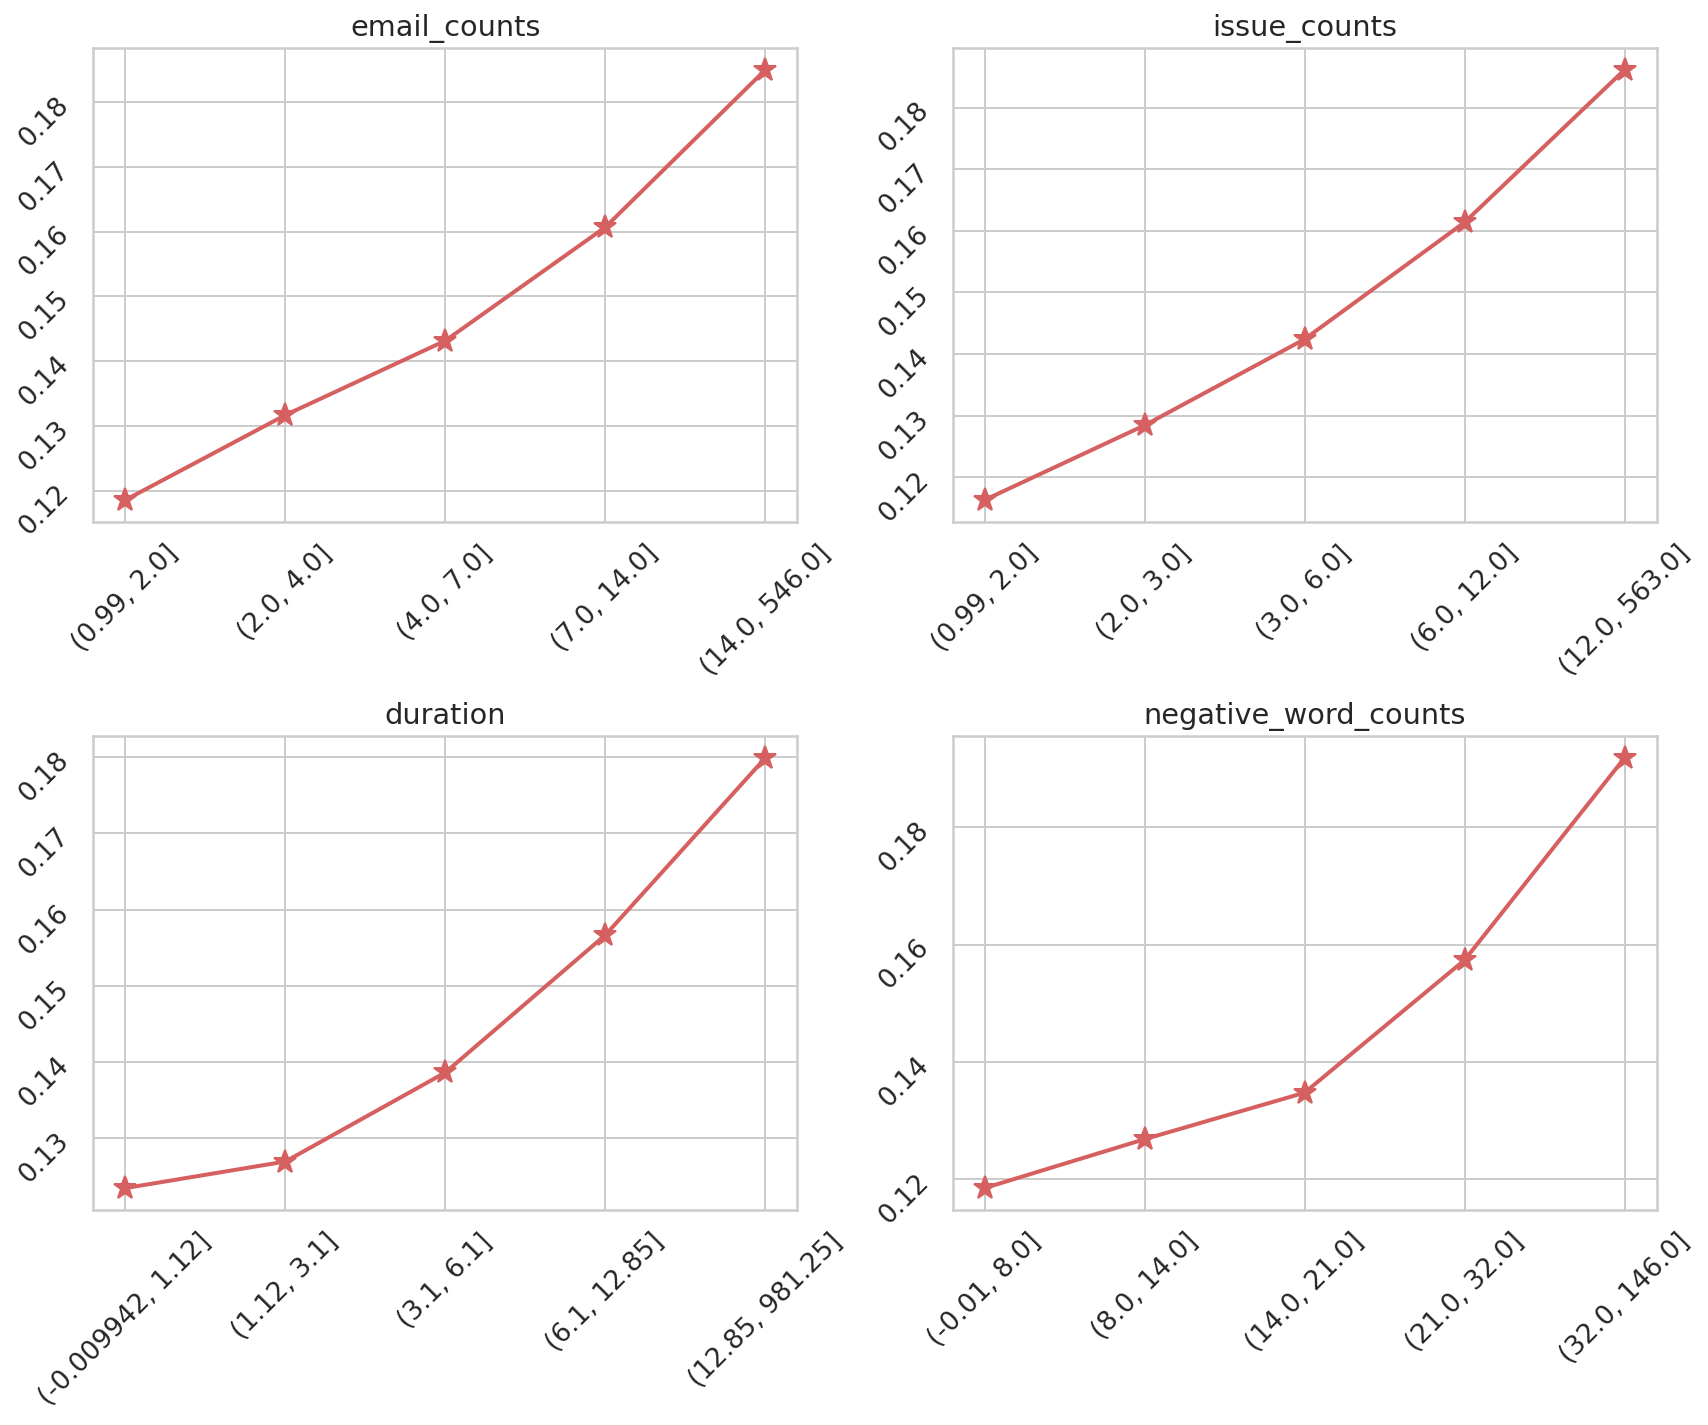

In [85]:
def pcut_func(df,var,nbin=5):
    df[var]=df[var].astype(float)
    df["cut"]=pd.qcut(df[var],nbin,precision=2,duplicates="drop")
    decile=df.groupby(df["cut"])['churn'].mean().reset_index()
    decile["cut"]=decile["cut"].astype(str)
    return decile

def myplot(df,var,*args):

    fig, a = plt.subplots(len(args)//2,2,figsize=(12,2.5*len(args)))
    a=a.ravel()
    for idx,ax in enumerate(a):
        df=args[idx]
        ax.plot(df["cut"],df["churn"],color="r",marker="*",linewidth=2, markersize=12)
        ax.set_title(var[idx])
        ax.tick_params(labelrotation=45)
    fig.tight_layout()
    
variable_list=["email_counts","issue_counts","duration","negative_word_counts"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=pcut_func(train_df,var=variable_list[idx],nbin=nbin)
    args.append(x)
myplot(train_df,variable_list,*args)

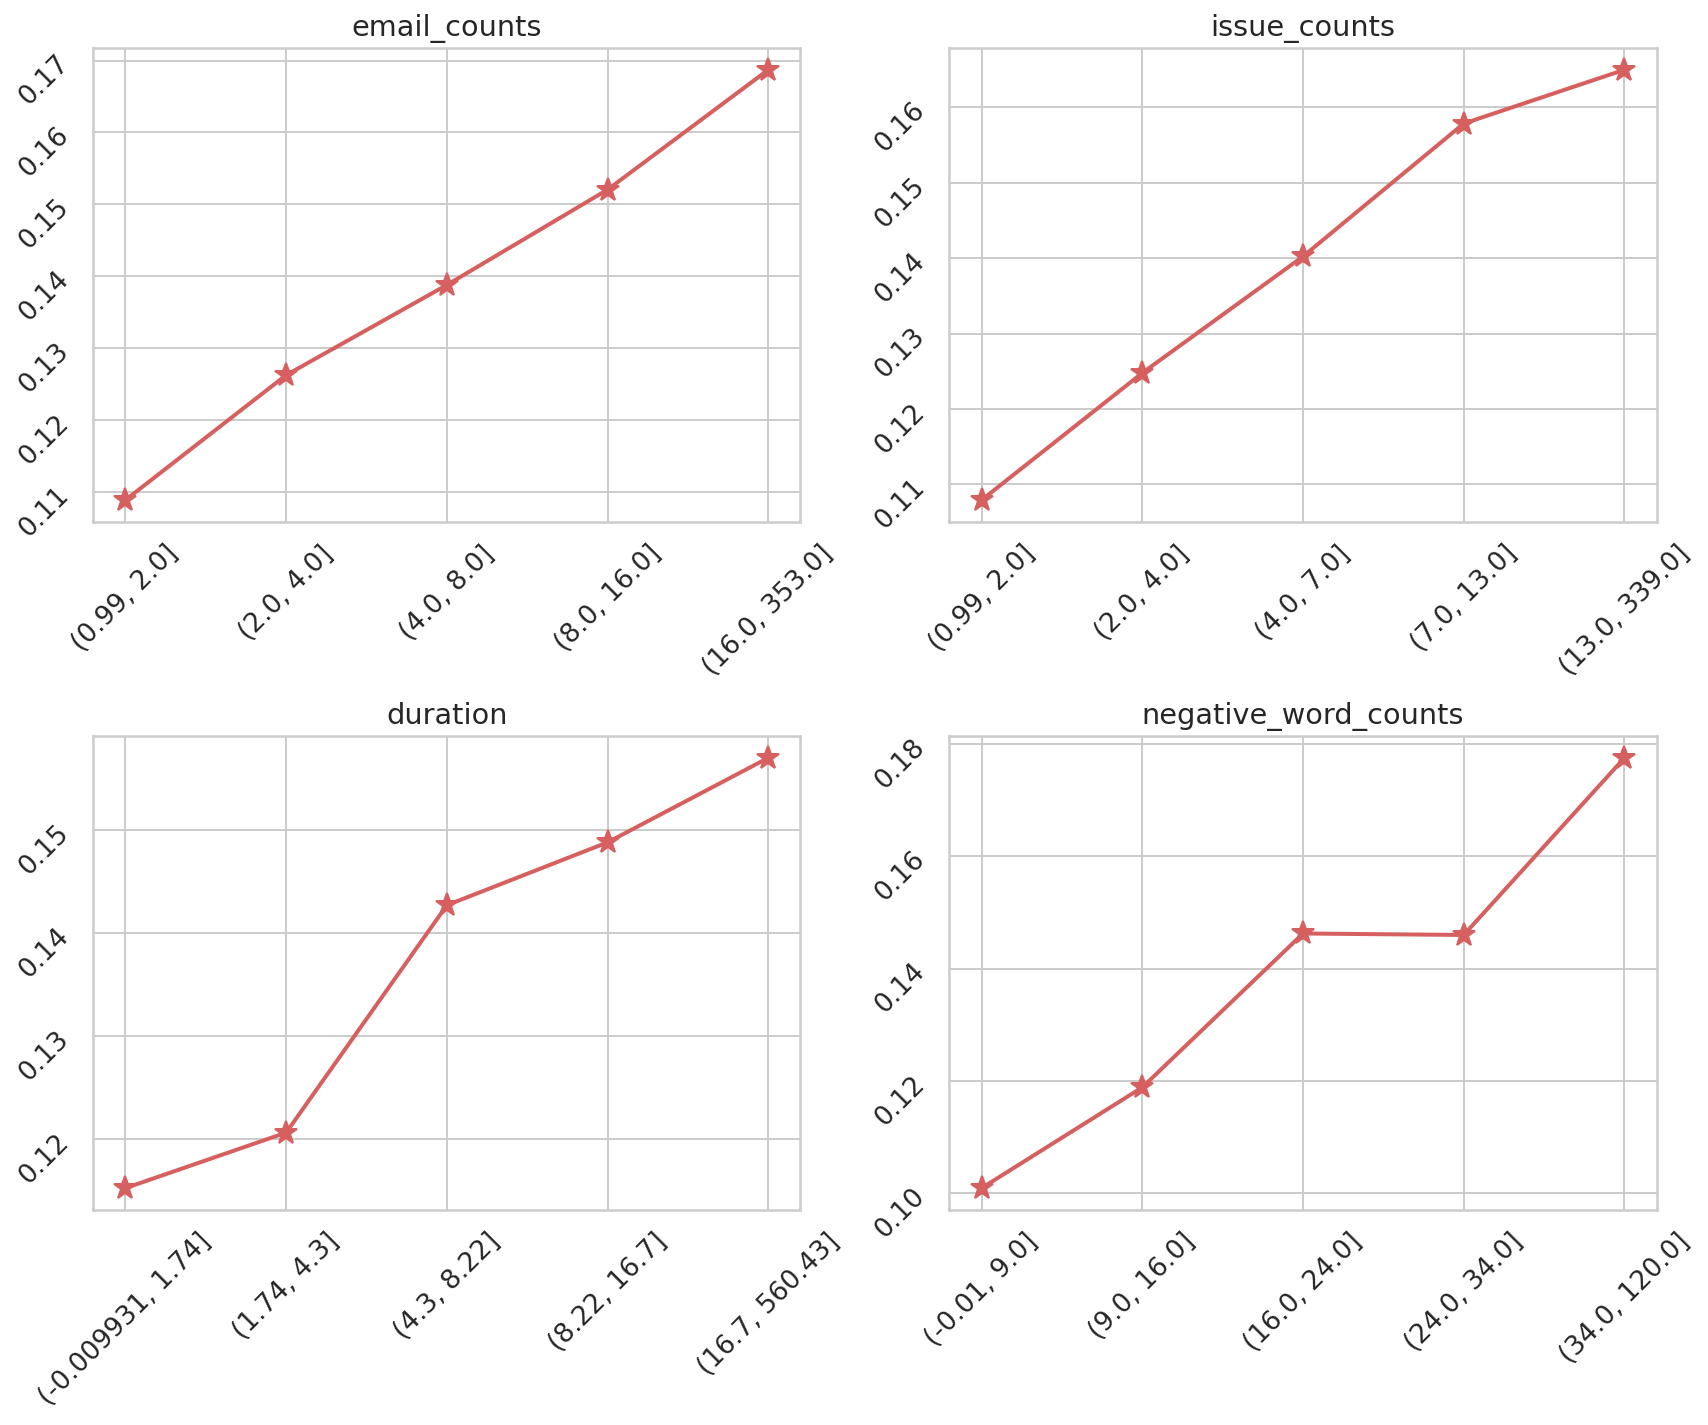

In [86]:
variable_list=["email_counts","issue_counts","duration","negative_word_counts"]
nbin=5
args=[]
for idx,v in enumerate(variable_list):
    x=pcut_func(test_df,var=variable_list[idx],nbin=nbin)
    args.append(x)
myplot(test_df,variable_list,*args)

#### catboosting

In [200]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

tempt=train_df.copy()
word=['terminate','termination','unsubscribe','unsubscribed','discontinue','discontinued']
tempt["termination_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )
x_train=tempt.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts","termination_word"]]
x_train["subtype"]=x_train["subtype"].astype(str)
x_train["termination_word"]=x_train["termination_word"].astype(str)
y_train=tempt.loc[:,["churn"]]

tempt=test_df.copy()
word=['terminate','termination','unsubscribe','unsubscribed','discontinue','discontinued']
tempt["termination_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )
x_test=tempt.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts","termination_word"]]
x_test["subtype"]=x_test["subtype"].astype(str)
x_test["termination_word"]=x_test["termination_word"].astype(str)
y_test=tempt.loc[:,["churn"]]

100%|██████████| 26812/26812 [00:01<00:00, 19716.78it/s]


In [201]:
x_train.head(2)

email_counts  issue_counts  duration                      subtype  \
0           1.0           1.0  5.396134  Coding Change or Correction   
1           1.0           1.0  0.838600              Renewal Inquiry   

   negative_word_counts termination_word  
0                   8.0                0  
1                   3.0                0

In [202]:
x_train.dtypes

email_counts            float64
issue_counts            float64
duration                float64
subtype                  object
negative_word_counts    float64
termination_word         object
dtype: object

In [203]:
from catboost import CatBoostClassifier, Pool

cat_features_names = [col for col in x_train.columns if x_train[col].dtypes=="object"]
cat_features = [x_train.columns.get_loc(col) for col in cat_features_names]

train_data = Pool(data=x_train,
                  label=y_train,
                  cat_features=cat_features
                 )

test_data = Pool(data=x_test,
                  label=y_test,
                  cat_features=cat_features
                 )

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'iterations': 1000,
          'learning_rate': 0.05,
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 50,
          'verbose': 200,
          'random_seed': 101
         }

clf = CatBoostClassifier(**params)
clf.fit(train_data, # instead of X_train, y_train
          eval_set=test_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5219090	best: 0.5219090 (0)	total: 12.7ms	remaining: 12.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5800574089
bestIteration = 111

Shrink model to first 112 iterations.


In [204]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score

def model_evaluate(target, predicted):
    
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    fscore=fscore[~np.isnan(fscore)]
    ix = np.argmax(fscore)
    f1_score=fscore[ix]
    

    auc=roc_auc_score(target, predicted)
    pr_auc=auc_score(recall,precision)

    thrs=thresholds[ix]
    prec=precision[ix]
    reca=recall[ix]

    true_label_mask=[1 if x>=thrs else 0 for i,x in enumerate(predicted)]

    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":prec, 
        "recall":reca, 
        "f1_score":f1_score,
        "AUC":auc,
        "pr_auc":pr_auc
    }

train_preds=clf.predict_proba(x_train)[:,1]
test_preds=clf.predict_proba(x_test)[:,1]
train_eval=model_evaluate(y_train, train_preds)
test_eval=model_evaluate(y_test, test_preds)

In [205]:
def evaluation_table(train_eval,test_eval):
    dict_data={}
    dict_data["data_type"]=["training set","test set"]
    dict_data["# of sample"]=[train_eval['nb_example'],test_eval['nb_example']]
    # dict_data["true_prediction"]=[train_eval['true_prediction'],test_eval['true_prediction']]
    # dict_data["false_prediction"]=[train_eval['false_prediction'],test_eval['false_prediction']]
    # dict_data["accuracy"]=[train_eval['accuracy'],test_eval['accuracy']]
    dict_data["precision"]=[train_eval['precision'],test_eval['precision']]  
    dict_data["recall"]=[train_eval['recall'],test_eval['recall']] 
    dict_data["f1_score"]=[train_eval['f1_score'],test_eval['f1_score']] 
    dict_data["ROC-AUC"]=[train_eval['AUC'],test_eval['AUC']] 
    dict_data["pr-auc"]=[train_eval['pr_auc'],test_eval['pr_auc']] 
    data_df=pd.DataFrame(dict_data)
    # data_df=data_df.set_index("Model Type")
    # data_df.style.format({"# of sample":"{:,}","true_prediction":"{:,}","false_prediction":"{:,}","accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    return data_df.style.format({"# of sample":"{:,}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    .set_caption("Model Performance Comparison")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [206]:
evaluation_table(train_eval,test_eval)

- ignore feature of existing termination_word
- add feature of existing frustration_word

In [257]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

tempt=train_df.copy()
word=["frustration","frustrated","frustrate","unacceptable","apologies","apologize","error","incorrect","incorrectly","inconvenience","unfortunately","wrong"]
tempt["selected_negative_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )
x_train=tempt.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts","selected_negative_word"]]
x_train["subtype"]=x_train["subtype"].astype(str)
x_train["selected_negative_word"]=x_train["selected_negative_word"].astype(str)
y_train=tempt.loc[:,["churn"]]

tempt=test_df.copy()
word=["frustration","frustrated","frustrate","unacceptable","apologies","apologize","error","incorrect","incorrectly","inconvenience","unfortunately","wrong"]
tempt["selected_negative_word"]=tempt["bag_of_word"].progress_apply(lambda x: 1 if len(set(word).intersection(set(x.split())))!=0 else 0 )
x_test=tempt.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts","selected_negative_word"]]
x_test["subtype"]=x_test["subtype"].astype(str)
x_test["selected_negative_word"]=x_test["selected_negative_word"].astype(str)
y_test=tempt.loc[:,["churn"]]

from catboost import CatBoostClassifier, Pool

cat_features_names = [col for col in x_train.columns if x_train[col].dtypes=="object"]
cat_features = [x_train.columns.get_loc(col) for col in cat_features_names]

train_data = Pool(data=x_train,
                  label=y_train,
                  cat_features=cat_features
                 )

test_data = Pool(data=x_test,
                  label=y_test,
                  cat_features=cat_features
                 )

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'iterations': 1000,
          'learning_rate': 0.05,
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 50,
          'verbose': 200,
          'random_seed': 101
         }

clf = CatBoostClassifier(**params)
clf.fit(train_data, # instead of X_train, y_train
          eval_set=test_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );

train_preds=clf.predict_proba(x_train)[:,1]
test_preds=clf.predict_proba(x_test)[:,1]
train_eval=model_evaluate(y_train, train_preds)
test_eval=model_evaluate(y_test, test_preds)
evaluation_table(train_eval,test_eval)

100%|██████████| 26812/26812 [00:01<00:00, 21834.94it/s]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5317875	best: 0.5317875 (0)	total: 13.3ms	remaining: 13.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.580674915
bestIteration = 125

Shrink model to first 126 iterations.


In [258]:
clf.get_feature_importance(prettified=True)

Feature Id  Importances
0                 subtype    31.509689
1    negative_word_counts    20.421272
2            issue_counts    18.538743
3                duration    13.544275
4            email_counts     9.034368
5  selected_negative_word     6.951653

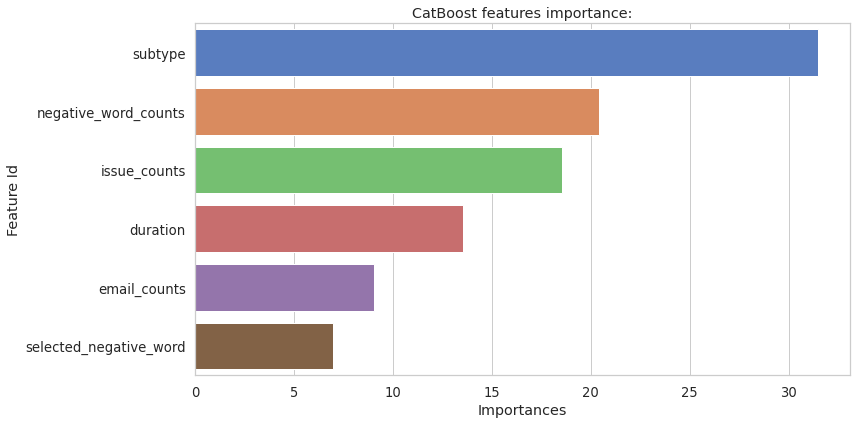

In [259]:
# clf.get_feature_importance(prettified=True)
feature_importance_df = pd.DataFrame(clf.get_feature_importance(prettified=True))
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

In [230]:
pd.DataFrame(clf.get_feature_importance(prettified=True)).columns

Index(['Feature Id', 'Importances'], dtype='object')

### textblob sentiment polarity

In [189]:
train_df["sentiment"]=train_df["adj_bag_of_word"].progress_apply(textblob_sentiment)
test_df["sentiment"]=test_df["adj_bag_of_word"].progress_apply(textblob_sentiment)

100%|██████████| 26812/26812 [00:11<00:00, 2253.68it/s]


positive    153987
neutral       1587
negative      1041
Name: sentiment, dtype: int64

In [190]:
tempt1=pd.DataFrame(train_df["sentiment"].value_counts(dropna=False)).reset_index().rename(columns={'index':'sentiment','sentiment':'count'})
tempt2=pd.DataFrame(train_df["sentiment"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'sentiment','sentiment':'percentage'})
tempt1.merge(tempt2, on="sentiment", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'})\
                                             .set_caption("Training Set Sentiment distribution")\
                                             .set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

In [191]:
tempt1=pd.DataFrame(test_df["sentiment"].value_counts(dropna=False)).reset_index().rename(columns={'index':'sentiment','sentiment':'count'})
tempt2=pd.DataFrame(test_df["sentiment"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'sentiment','sentiment':'percentage'})
tempt1.merge(tempt2, on="sentiment", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'})\
                                             .set_caption("Test Set Sentiment distribution")\
                                             .set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

#### TF-IDF features

In [74]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train_df['bag_of_word'])

top_sum=bow.toarray().sum(axis=0)
top_sum_cv=[top_sum]
columns_cv = bow_vectorizer.get_feature_names()
x_traincvdf = pd.DataFrame(top_sum_cv,columns=columns_cv)
import operator
dic = {}
for i in range(len(top_sum_cv[0])):
    dic[columns_cv[i]]=top_sum_cv[0][i]
sorted_dic=sorted(dic.items(),reverse=True,key=operator.itemgetter(1))
print(sorted_dic[0:100])

[('center', 10967.109384445563), ('message', 10556.358043184136), ('success', 10486.37801945131), ('covid', 9838.049072634305), ('group', 9431.559335914642), ('policy', 8974.543771000765), ('claim', 8858.58538258112), ('intended', 8479.844126869688), ('coverage', 8356.880053902652), ('mail', 7700.830059756591), ('life', 7469.444730583948), ('request', 6967.753188357165), ('enrollment', 6960.929021927049), ('great', 6781.677461238403), ('contact', 6653.128091134836), ('associate', 6436.606378454984), ('insurance', 5990.346950047528), ('office', 5886.439144939938), ('good', 5816.90283112778), ('suite', 5773.519966896564), ('access', 5691.32743583263), ('process', 5624.74085103013), ('recipient', 5334.042546255625), ('account', 5324.46855635867), ('new', 5244.151754863522), ('form', 5227.768654590049), ('plan', 5215.705097528352), ('effective', 5133.843641408491), ('hope', 4922.953020499623), ('add', 4843.8396220899185), ('invoice', 4820.287144332153), ('confidential', 4807.07562840613), 

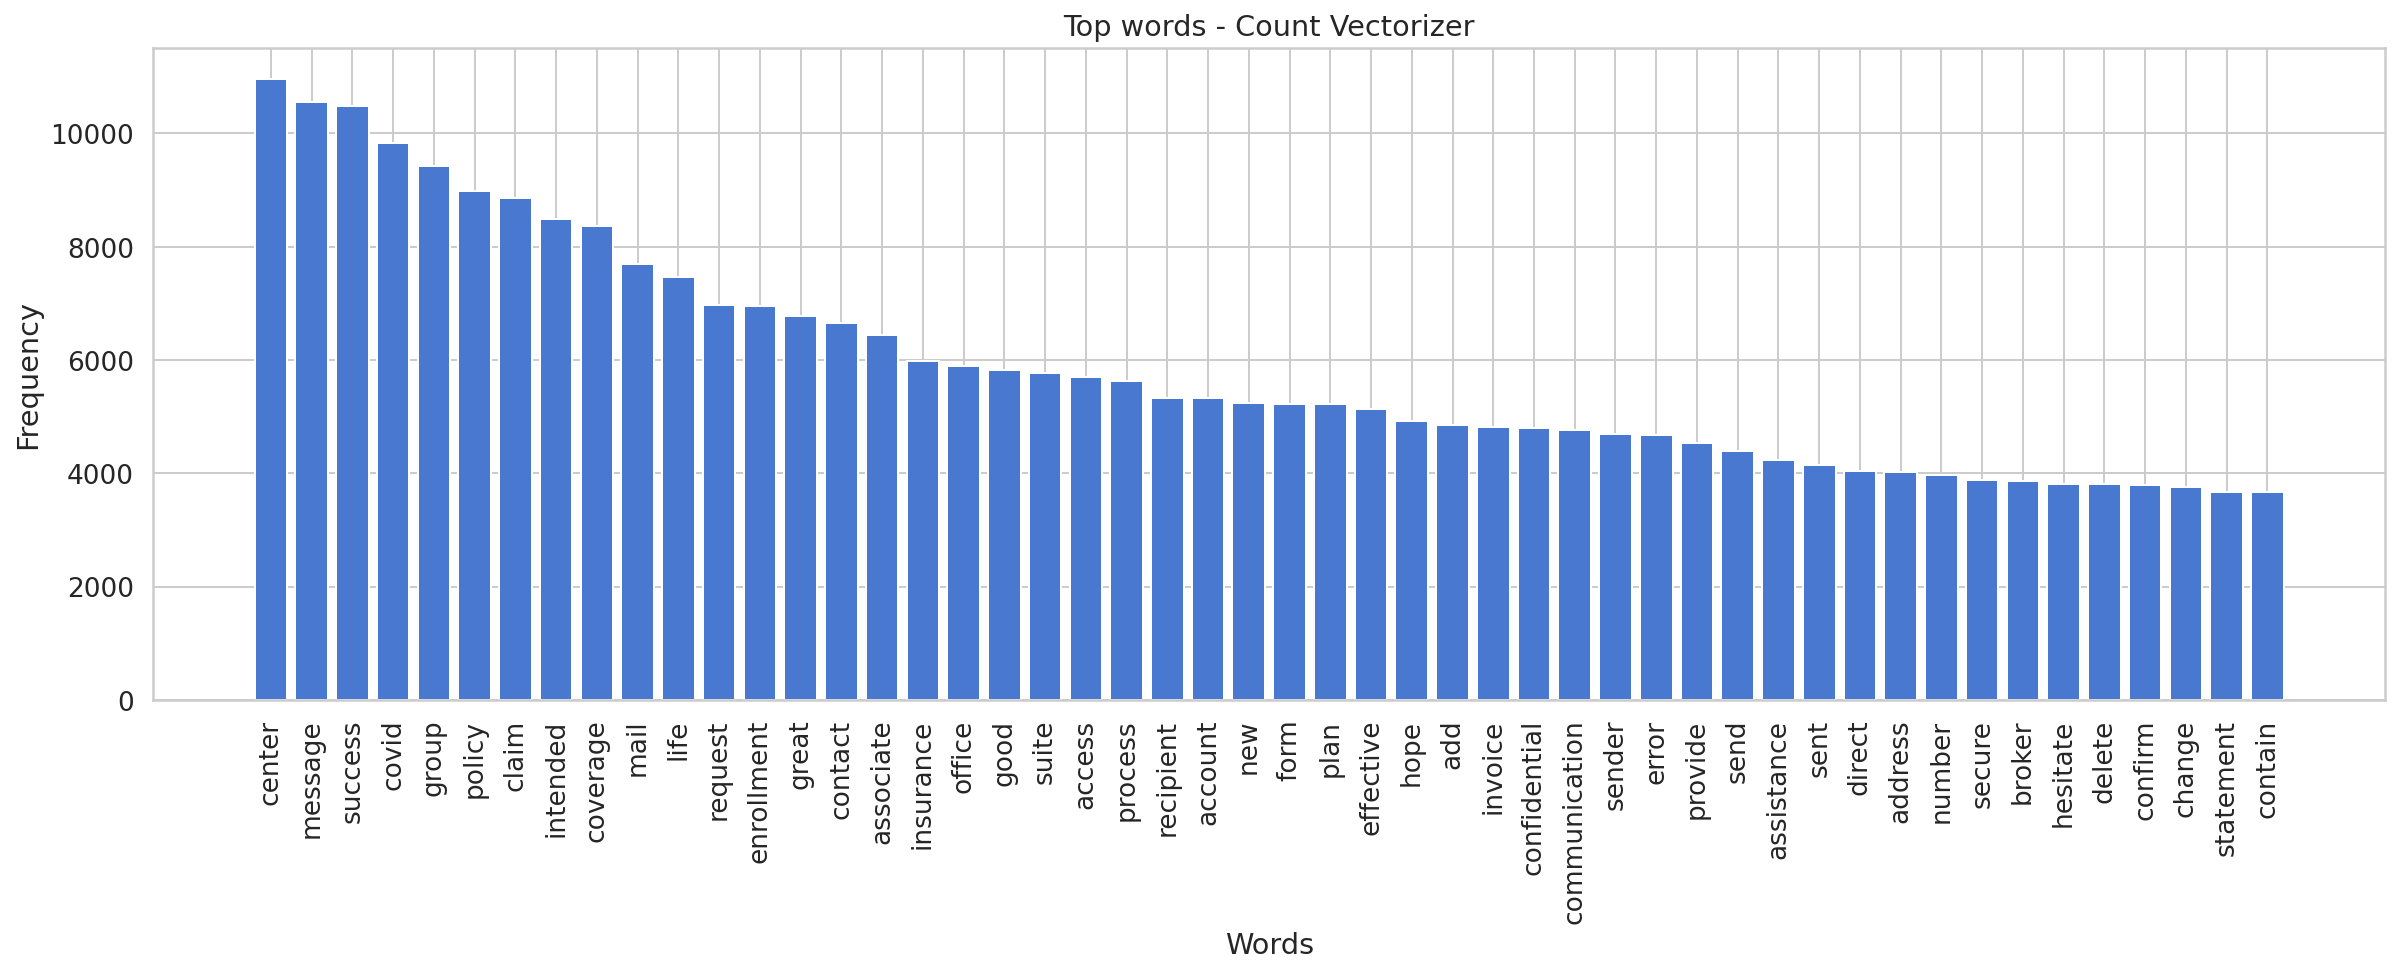

In [75]:
from matplotlib import pyplot as plt

sorted_dic = sorted_dic[:50]

xs, ys = [*zip(*sorted_dic)]


plt.figure(figsize=(20,6))
plt.bar(xs, ys)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top words - Count Vectorizer')
plt.xticks(rotation=90)
plt.show()

In [149]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [238]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train_df['bag_of_word'])
train_tfidf = bow.toarray()
vocab = bow_vectorizer.get_feature_names()
vocab = np.array(vocab)
train_tfidf = pd.DataFrame(train_tfidf,columns=vocab)

test_tfidf = bow_vectorizer.transform(test_df['bag_of_word'])
test_tfidf = test_tfidf.toarray()
test_tfidf = pd.DataFrame(test_tfidf,columns=vocab)

In [239]:
from catboost import CatBoostClassifier, Pool

cat_features_names = [col for col in train_tfidf.columns if train_tfidf[col].dtypes=="object"]
cat_features = [train_tfidf.columns.get_loc(col) for col in cat_features_names]

train_data = Pool(data=train_tfidf,
                  label=y_train,
                  cat_features=cat_features
                 )

test_data = Pool(data=test_tfidf,
                  label=y_test,
                  cat_features=cat_features
                 )

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'iterations': 1000,
          'learning_rate': 0.05,
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 50,
          'verbose': 200,
          'random_seed': 101
         }

clf = CatBoostClassifier(**params)
clf.fit(train_data, # instead of X_train, y_train
          eval_set=test_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5485567	best: 0.5485567 (0)	total: 38.8ms	remaining: 38.8s
200:	test: 0.6050434	best: 0.6053916 (189)	total: 8.01s	remaining: 31.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6083886487
bestIteration = 263

Shrink model to first 264 iterations.


In [240]:
train_preds=clf.predict_proba(train_tfidf)[:,1]
test_preds=clf.predict_proba(test_tfidf)[:,1]
train_eval=model_evaluate(y_train, train_preds)
test_eval=model_evaluate(y_test, test_preds)
evaluation_table(train_eval,test_eval)

### TF-IDF Features + Structure Data features

In [262]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

x_train=train_df.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts"]]
x_train["subtype"]=x_train["subtype"].astype(str)
y_train=train_df.loc[:,["churn"]]

x_test=test_df.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts"]]
x_test["subtype"]=x_test["subtype"].astype(str)
y_test=test_df.loc[:,["churn"]]

X_Train=pd.concat([train_tfidf.reset_index(drop=True),x_train.reset_index(drop=True)],axis=1)
X_Test=pd.concat([test_tfidf.reset_index(drop=True),x_test.reset_index(drop=True)],axis=1)

In [263]:
from catboost import CatBoostClassifier, Pool

cat_features_names = [col for col in X_Train.columns if X_Train[col].dtypes=="object"]
cat_features = [X_Train.columns.get_loc(col) for col in cat_features_names]

train_data = Pool(data=X_Train,
                  label=y_train,
                  cat_features=cat_features
                 )

test_data = Pool(data=X_Test,
                  label=y_test,
                  cat_features=cat_features
                 )

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'iterations': 1000,
          'learning_rate': 0.05,
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 50,
          'verbose': 200,
          'random_seed': 101
         }

clf = CatBoostClassifier(**params)
clf.fit(train_data, # instead of X_train, y_train
          eval_set=test_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5355310	best: 0.5355310 (0)	total: 55.6ms	remaining: 55.5s
200:	test: 0.6059752	best: 0.6069416 (174)	total: 12s	remaining: 47.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6074760035
bestIteration = 234

Shrink model to first 235 iterations.


In [265]:
train_preds=clf.predict_proba(X_Train)[:,1]
test_preds=clf.predict_proba(X_Test)[:,1]
train_eval=model_evaluate(y_train, train_preds)
test_eval=model_evaluate(y_test, test_preds)
evaluation_table(train_eval,test_eval)

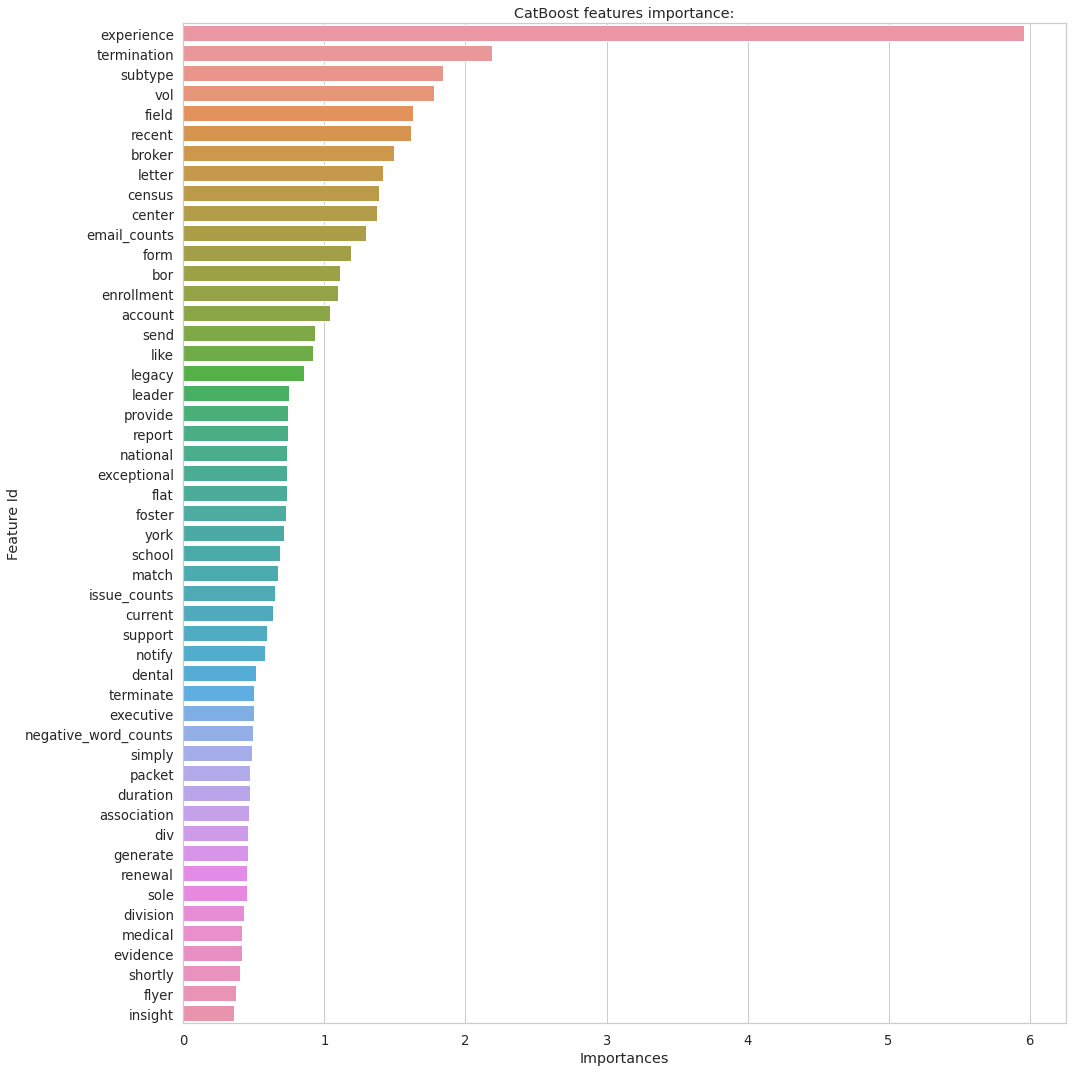

In [270]:
# clf.get_feature_importance(prettified=True)
feature_importance_df = pd.DataFrame(clf.get_feature_importance(prettified=True)).iloc[0:50]
plt.figure(figsize=(15, 15));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

#### 100 TF-IDF feature

In [199]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=100, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train_df['bag_of_word'])
train_tfidf = bow.toarray()
vocab = bow_vectorizer.get_feature_names()
vocab = np.array(vocab)
train_tfidf = pd.DataFrame(train_tfidf,columns=vocab)

test_tfidf = bow_vectorizer.transform(test_df['bag_of_word'])
test_tfidf = test_tfidf.toarray()
test_tfidf = pd.DataFrame(test_tfidf,columns=vocab)

x_train=train_df.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts"]]
x_train["subtype"]=x_train["subtype"].astype(str)
y_train=train_df.loc[:,["churn"]]

x_test=test_df.loc[:,["email_counts","issue_counts","duration","subtype","negative_word_counts"]]
x_test["subtype"]=x_test["subtype"].astype(str)
y_test=test_df.loc[:,["churn"]]

X_Train=pd.concat([train_tfidf.reset_index(drop=True),x_train.reset_index(drop=True)],axis=1)
X_Test=pd.concat([test_tfidf.reset_index(drop=True),x_test.reset_index(drop=True)],axis=1)

from catboost import CatBoostClassifier, Pool

cat_features_names = [col for col in X_Train.columns if X_Train[col].dtypes=="object"]
cat_features = [X_Train.columns.get_loc(col) for col in cat_features_names]

train_data = Pool(data=X_Train,
                  label=y_train,
                  cat_features=cat_features
                 )

test_data = Pool(data=X_Test,
                  label=y_test,
                  cat_features=cat_features
                 )

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'iterations': 1000,
          'learning_rate': 0.05,
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 50,
          'verbose': 200,
          'random_seed': 101
         }

clf = CatBoostClassifier(**params)
clf.fit(train_data, # instead of X_train, y_train
          eval_set=test_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );
train_preds=clf.predict_proba(X_Train)[:,1]
test_preds=clf.predict_proba(X_Test)[:,1]
train_eval=model_evaluate(y_train, train_preds)
test_eval=model_evaluate(y_test, test_preds)
evaluation_table(train_eval,test_eval)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5314453	best: 0.5314453 (0)	total: 35.8ms	remaining: 35.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5985796552
bestIteration = 104

Shrink model to first 105 iterations.


### Word Count

100%|██████████| 156626/156626 [03:29<00:00, 748.17it/s]


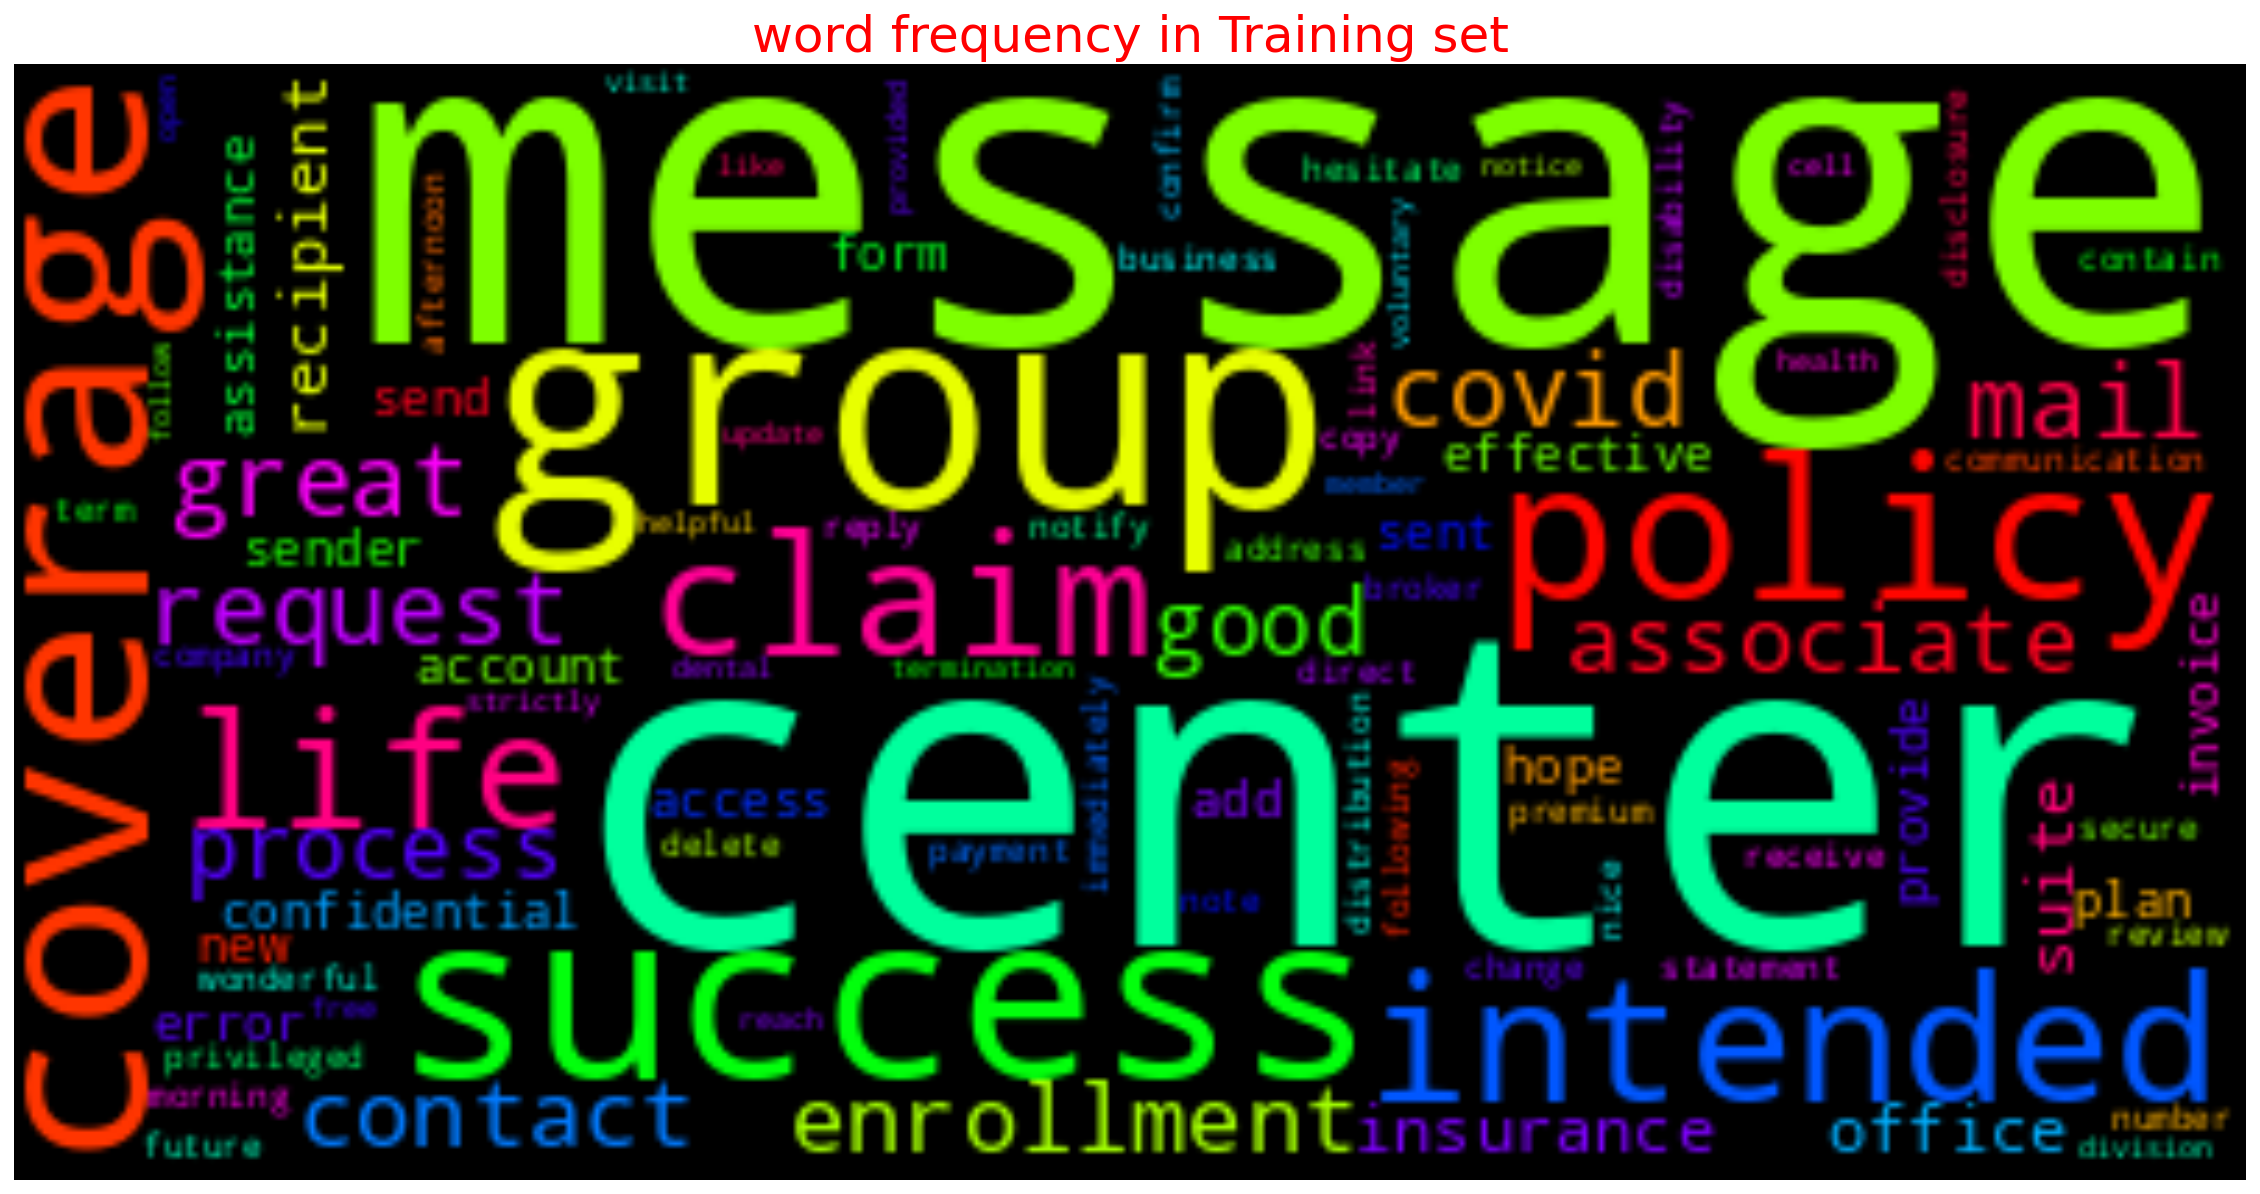

In [80]:
train_word=[]
for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    text_tokens = word_tokenize(row["bag_of_word"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    # train_word.extend(filter_text.lower().split())
    train_word.extend(filter_text)
    
train_dict=Counter(train_word)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(train_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Training set", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

100%|██████████| 26819/26819 [00:42<00:00, 633.07it/s]


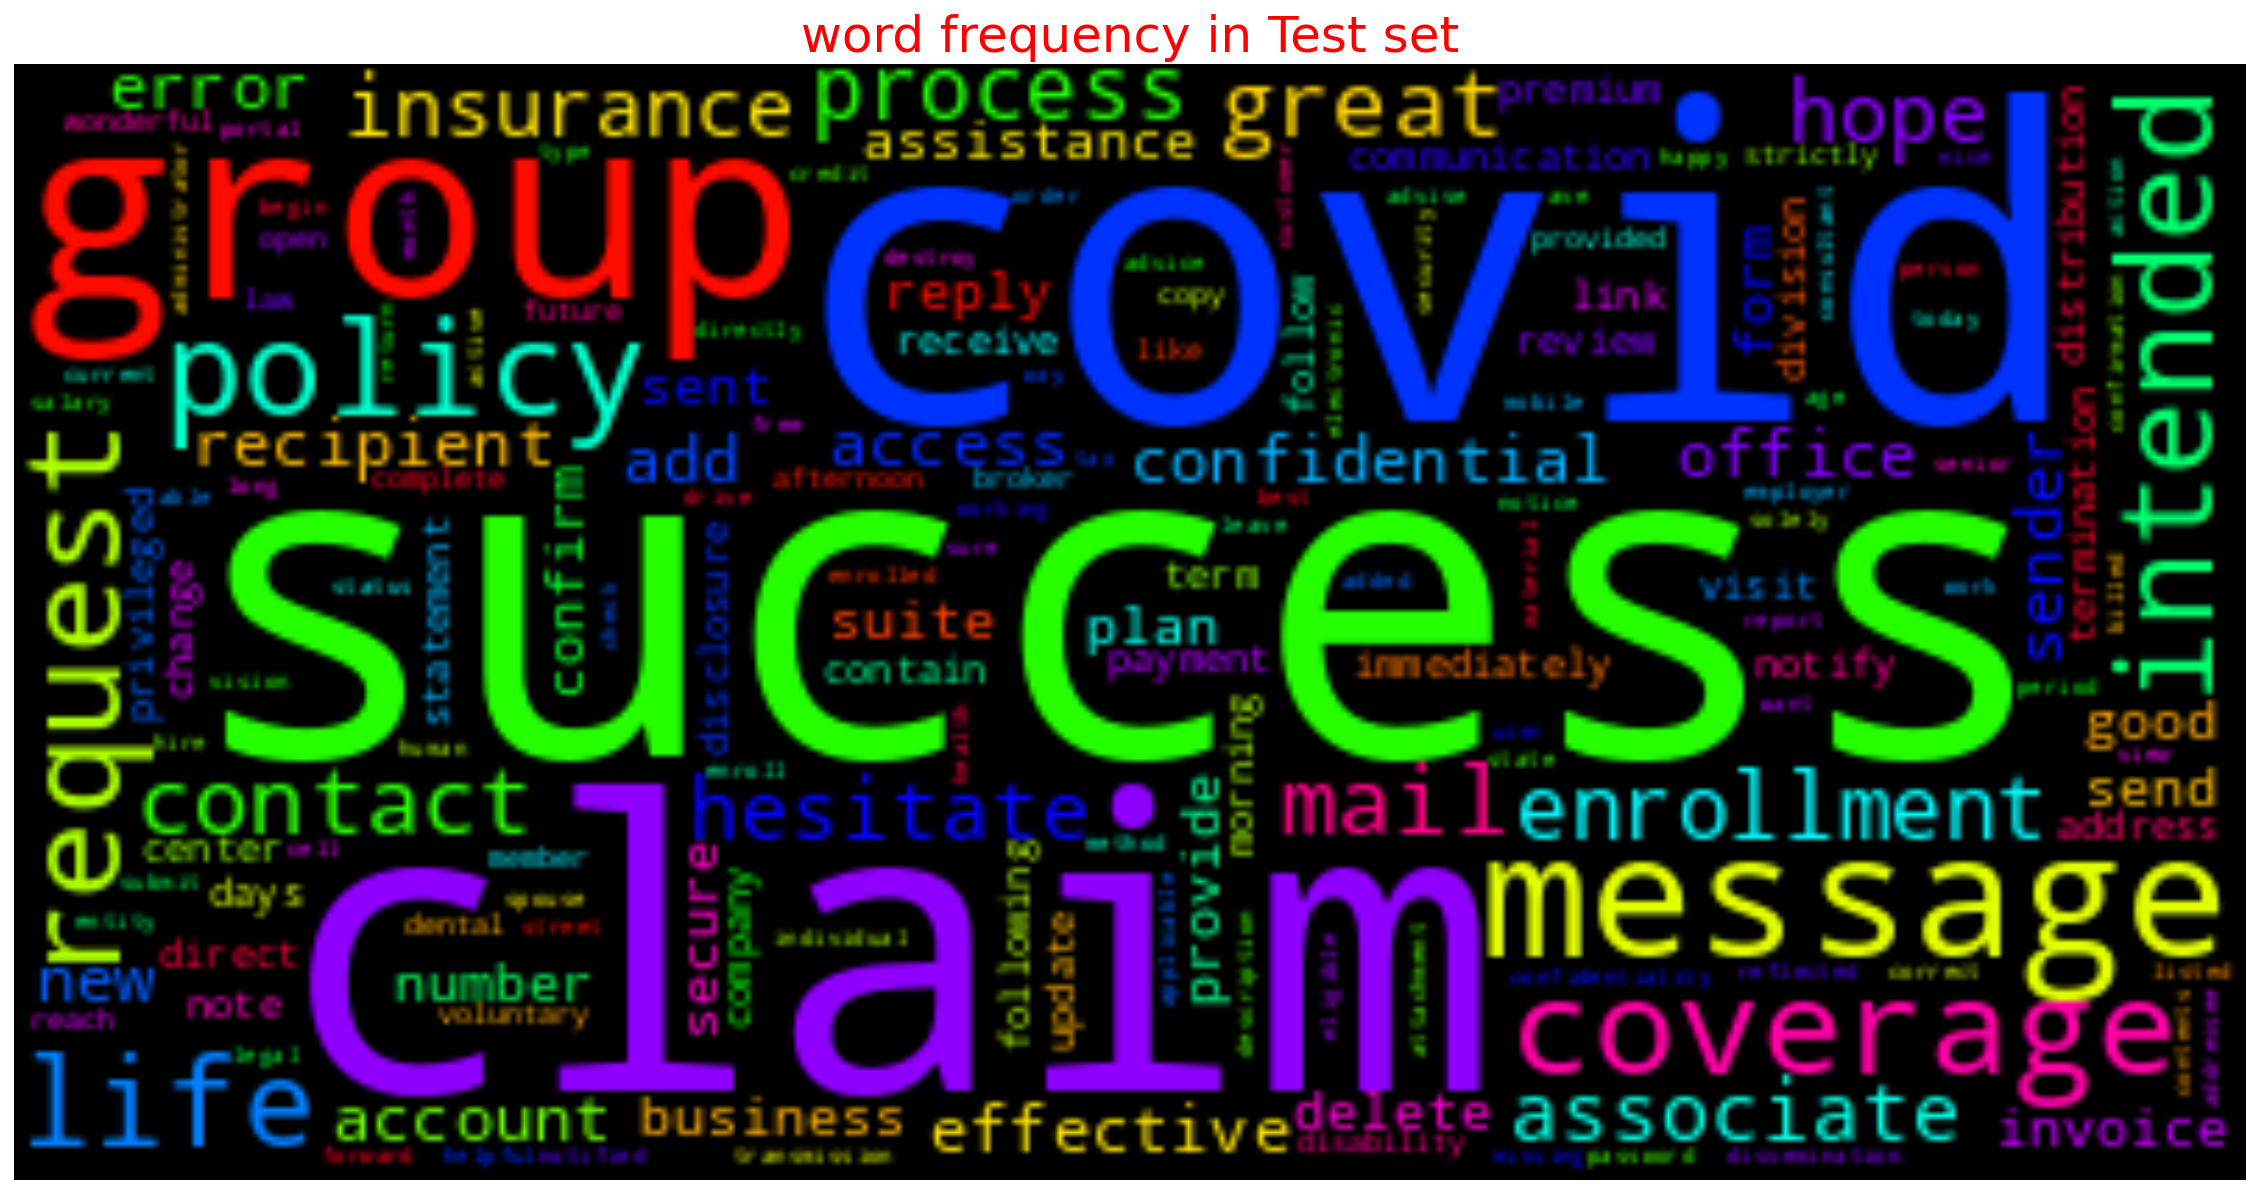

In [81]:
test_word=[]
for index, row in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    text_tokens = word_tokenize(row["bag_of_word"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    # test_word.extend(filter_text.lower().split())
    test_word.extend(filter_text)
    
test_dict=Counter(test_word)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(test_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Test set", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

100%|██████████| 22732/22732 [00:36<00:00, 625.75it/s]


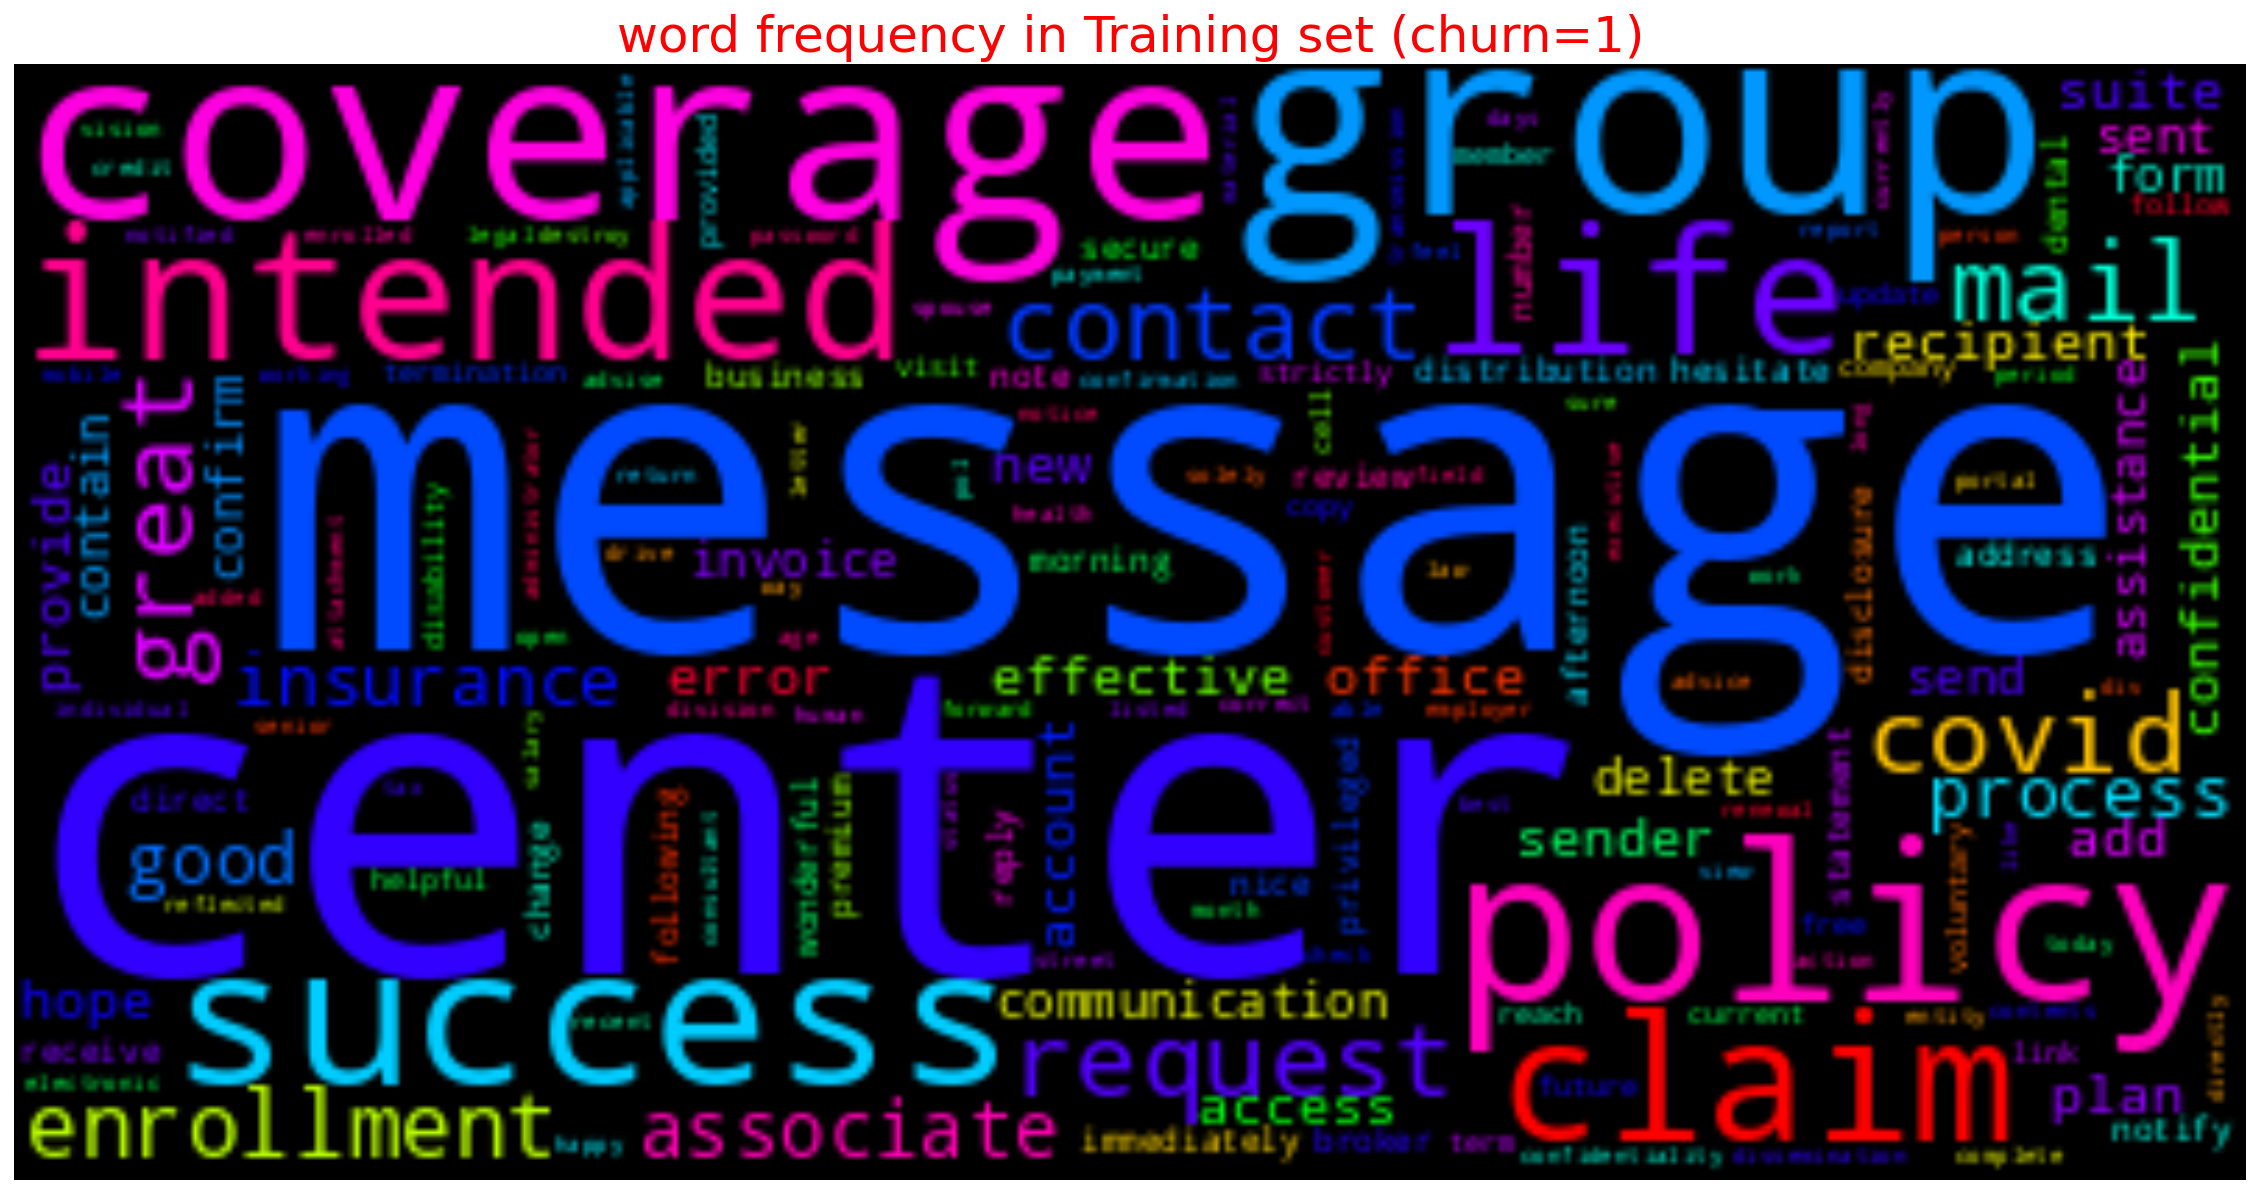

In [82]:
train_word_positive=[]
df_train_positive=df_train[df_train["churn"]==1]
for index, row in tqdm(df_train_positive.iterrows(), total=df_train_positive.shape[0]):
    text_tokens = word_tokenize(row["bag_of_word"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    train_word_positive.extend(filter_text)
    
train_dict=Counter(train_word_positive)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(train_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Training set (churn=1)", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

100%|██████████| 3670/3670 [00:06<00:00, 551.93it/s]


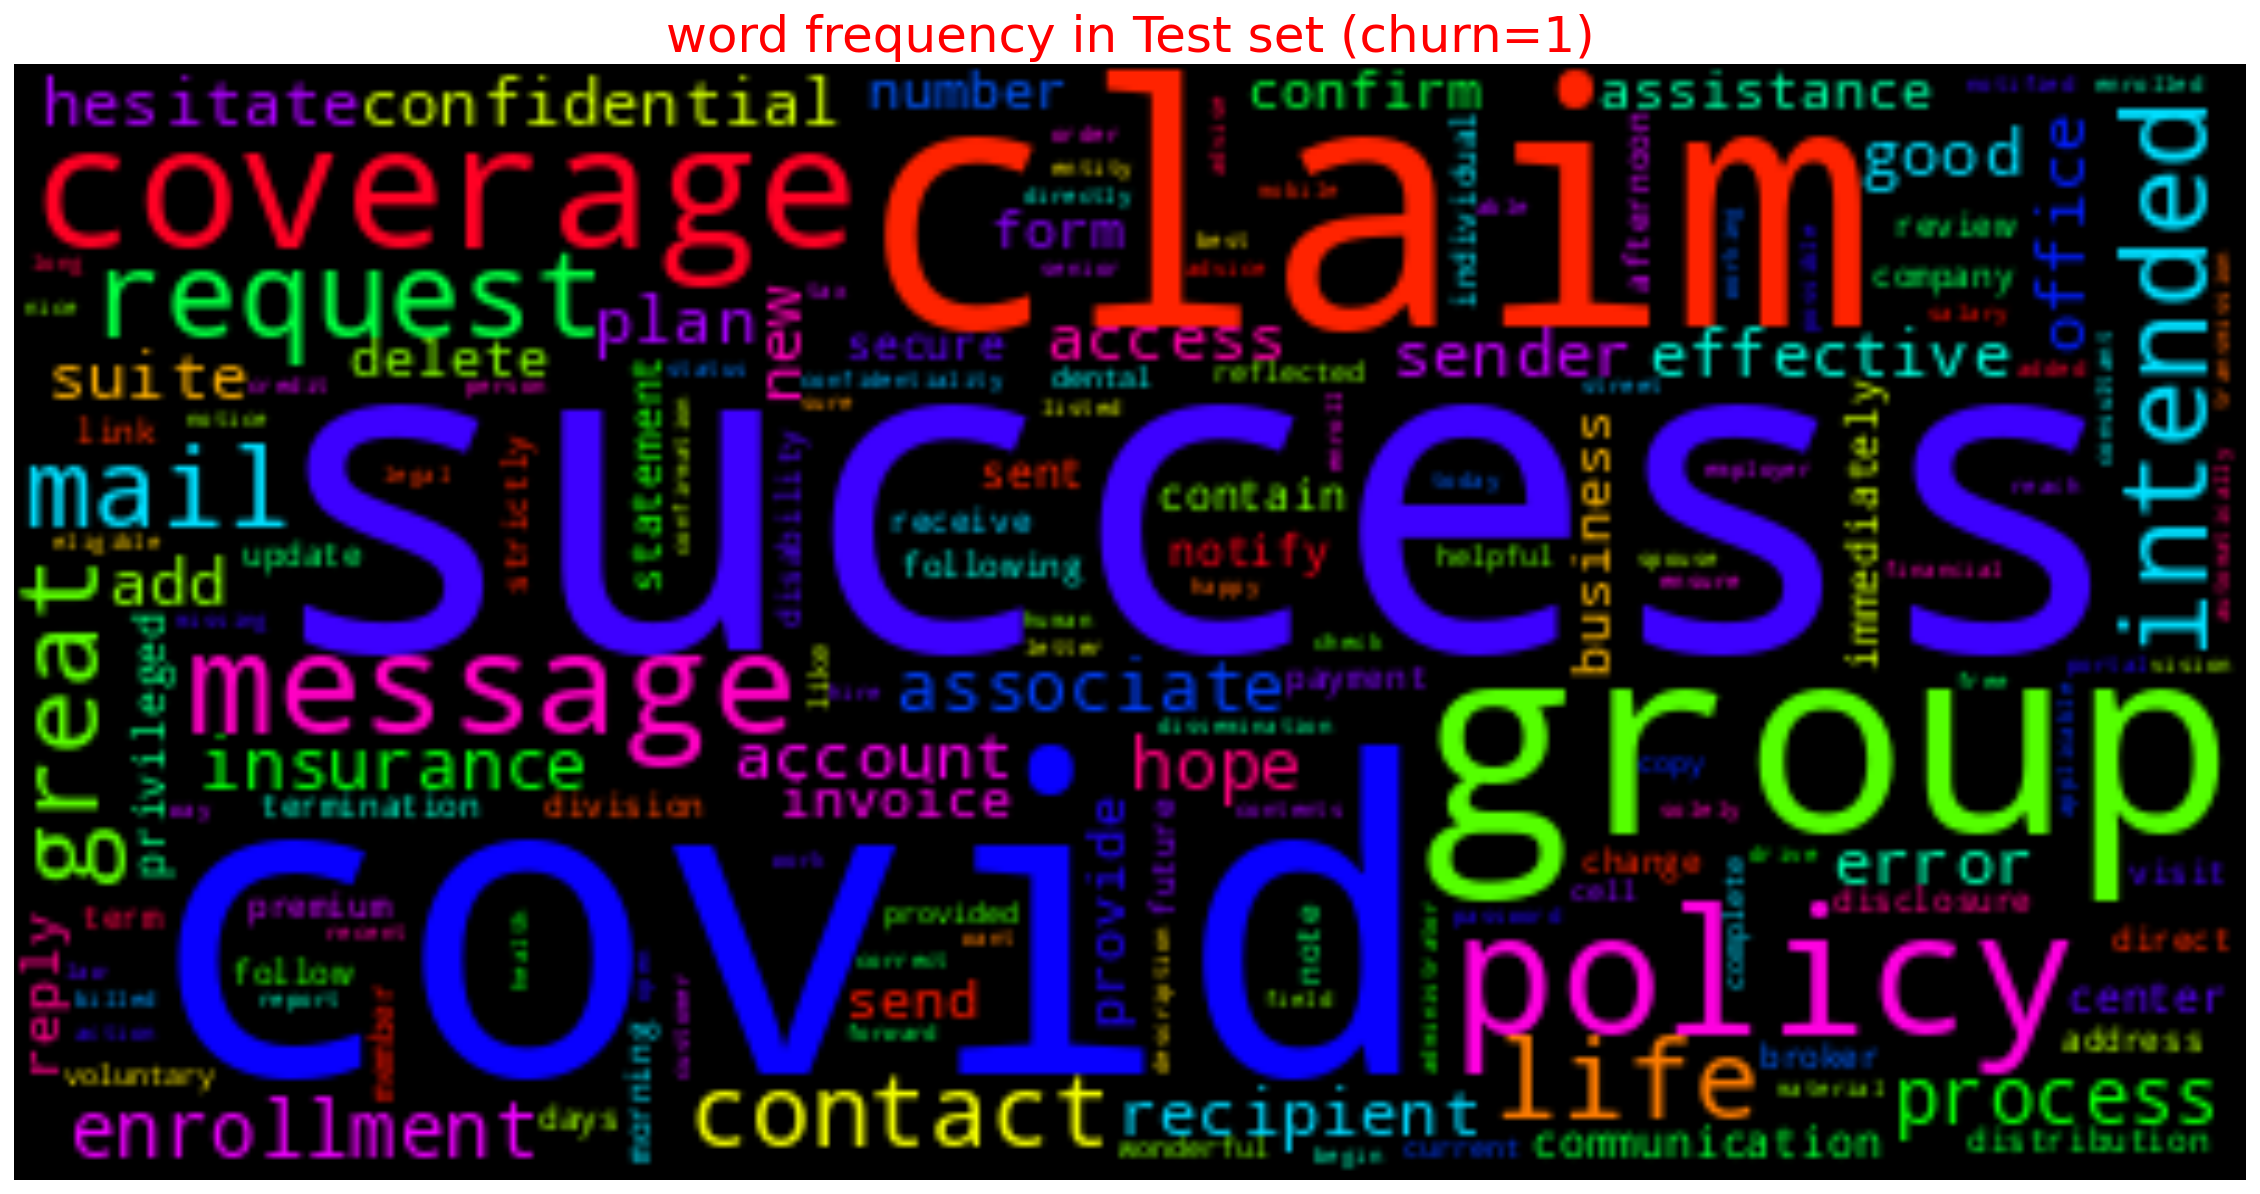

In [83]:
test_word_positive=[]
df_test_positive=df_test[df_test["churn"]==1]
for index, row in tqdm(df_test_positive.iterrows(), total=df_test_positive.shape[0]):
    text_tokens = word_tokenize(row["bag_of_word"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    test_word_positive.extend(filter_text)
    
test_dict=Counter(test_word_positive)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(test_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Test set (churn=1)", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
def dummy_fun(doc):
    return doc.split()

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(input="content",analyzer='word',tokenizer=dummy_fun,max_features=1000)

In [ ]:
n=50
vectorizer.fit(df_train["Full_TextBody"])
df_tfidf = vectorizer.transform(df_train["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_train = np.argsort(df_tfidf.toarray()).flatten()[::-1]
train_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_train":vocab[tfidf_train][:n]})

vectorizer.fit(df_test["Full_TextBody"])
df_tfidf = vectorizer.transform(df_test["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_test = np.argsort(df_tfidf.toarray()).flatten()[::-1]
test_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_test":vocab[tfidf_test][:n]})

pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner")

In [ ]:
n=50

df_train_churn=df_train[df_train["churn"]==1]
vectorizer.fit(df_train_churn["Full_TextBody"])
df_tfidf = vectorizer.transform(df_train_churn["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_train = np.argsort(df_tfidf.toarray()).flatten()[::-1]
train_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_train":vocab[tfidf_train][:n]})

df_test_churn=df_test[df_test["churn"]==1]
vectorizer.fit(df_test_churn["Full_TextBody"])
df_tfidf = vectorizer.transform(df_test_churn["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_test = np.argsort(df_tfidf.toarray()).flatten()[::-1]
test_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_test":vocab[tfidf_test][:n]})

pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner")

In [ ]:
pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner").shape

In [ ]:
pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner").drop_duplicates().shape

In [ ]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    
hf_train.set_format(type="pandas")
df_train=hf_train[:]
hf_test.set_format(type="pandas")
df_test=hf_test[:]

df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)

import textwrap
import random

df_test_v1=df_test[(df_test.churn==1) & (df_test.Full_Words_length<=512)]
df_test_v1=df_test_v1.dropna(subset=["Client_TextBody"])
# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=150) 

exam_1 = df_test_v1["Full_TextBody"]
exam_2 = df_test_v1["Client_TextBody"]
exam_3 = df_test_v1["Latest_TextBody"]

# Randomly choose some examples.
for i in range(10):
    random.seed(101+i)
    j = random.choice(exam_1.index)
    
    print('')
    print("*"*50)
    print('*********  Full TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_1[j]))
    print('')
    print("*"*50)
    print('*********  Client TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_2[j]))
    print('')
    print("*"*50)
    print('*********  Latest Parent_ID TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_3[j]))
    print('')
    print("*"*200)